**Table of contents**<a id='toc0_'></a>    
- [文件说明（File descriptions）](#toc1_)    
- [数据字段（Data fields）](#toc2_)    
- [导入库](#toc3_)    
- [EDA(数据探索性分析)](#toc4_)    
- [工具函数](#toc5_)    
- [数据预处理](#toc6_)    
- [特征工程](#toc7_)    
- [贝叶斯优化参数空间](#toc8_)    
- [合成数据生成](#toc9_)    
- [5 折交叉验证训练](#toc10_)    
- [模型融合](#toc11_)    
  - [加权融合（权重按 OOF F1 的幂次）](#toc11_1_)    
  - [Stacking（Logistic/RandomForest 选最佳）](#toc11_2_)    
- [提交文件](#toc12_)    
- [结果可视化](#toc13_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[文件说明（File descriptions）](#toc0_)
- train.csv - 训练集
- test.csv - 测试集
- sampleSubmission.csv - 格式正确的提交文件示例


# <a id='toc2_'></a>[数据字段（Data fields）](#toc0_)
- Home Ownership - 住房所有权（房屋拥有情况）
- Annual Income - 年收入
- Years in current job - 当前工作年限
- Tax Liens - 税收留置权（税务扣押权）
- Number of Open Accounts - 未结清账户数量（已开立账户数量）
- Years of Credit History - 信用历史年限
- Maximum Open Credit - 最高未结清信贷额度（曾向客户开放的最高信贷金额）
- Number of Credit Problems - 信用问题次数
- Months since last delinquent - 上次逾期至今的月数
- Bankruptcies - 破产次数
- Purpose - 贷款用途
- Term - 贷款期限
- Current Loan Amount - 当前贷款金额（客户仍需偿还的贷款余额）
- Current Credit Balance - 当前信用余额（客户可从信贷账户中使用的金额）
- Monthly Debt - 月债务金额（每月需偿还的债务）
- Credit Score - 信用评分
- Credit Default - 信贷违约情况（0 - 按时还清，1 - 逾期）

# <a id='toc3_'></a>[导入库](#toc0_)

In [1]:
# ==========================================
# 信用违约预测（LightGBM + XGBoost + CatBoost）
# 1. 自动贝叶斯优化（LGB/XGB/CAT）
# 2. 数据合成
# 3. 五折 StratifiedKFold 训练
# 4. 加权融合 + Stacking
# 5. SHAP 解释性 + ROC/PR 可视化
# ==========================================
import warnings, os, random, gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 设置全局字体，支持中文显示
# ----------------------------
# 解决中文字体 & findfont 报错
# ----------------------------
import matplotlib as mpl

# 让 matplotlib 走 “sans-serif 字体族”
mpl.rcParams["font.family"] = "sans-serif"

# 让中文字体排在最前（有哪个用哪个）
mpl.rcParams["font.sans-serif"] = [
    "SimHei",                # 万一你后来自己装了 SimHei
    "Noto Sans CJK SC",      # 你装了 fonts-noto-cjk 后通常就有
    "WenQuanYi Zen Hei",     # fonts-wqy-zenhei
    "WenQuanYi Micro Hei",   # fonts-wqy-microhei
    "Microsoft YaHei",
    "Arial Unicode MS",
    "DejaVu Sans",           # 最后兜底（不保证中文）
]

# 负号正常显示
mpl.rcParams["axes.unicode_minus"] = False


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import shap
shap.initjs()

In [2]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SAMPLE_SUB_PATH = "sample_submission.csv"
SUBMISSION_OUT = "submission.csv"

# <a id='toc4_'></a>[EDA(数据探索性分析)](#toc0_)

1. 查看表格数据全貌​
2. 分析数据特征类型与缺失值情况​
3. 探究类别特征与目标特征的关联关系​
4. 剖析数值特征的数据分布特征

In [3]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
display(train.head())

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Cement                          735 non-null    float64
 1   Blast Furnace Slag              735 non-null    float64
 2   Fly Ash                         735 non-null    float64
 3   Water                           735 non-null    float64
 4   Superplasticizer                735 non-null    float64
 5   Coarse Aggregate                735 non-null    float64
 6   Fine Aggregate                  735 non-null    float64
 7   Age (day)                       735 non-null    int64  
 8   Concrete compressive strength   735 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 51.8 KB


In [5]:
print(train.isnull().sum()) #checking for total null values

Cement                            0
Blast Furnace Slag                0
Fly Ash                           0
Water                             0
Superplasticizer                  0
Coarse Aggregate                  0
Fine Aggregate                    0
Age (day)                         0
Concrete compressive strength     0
dtype: int64


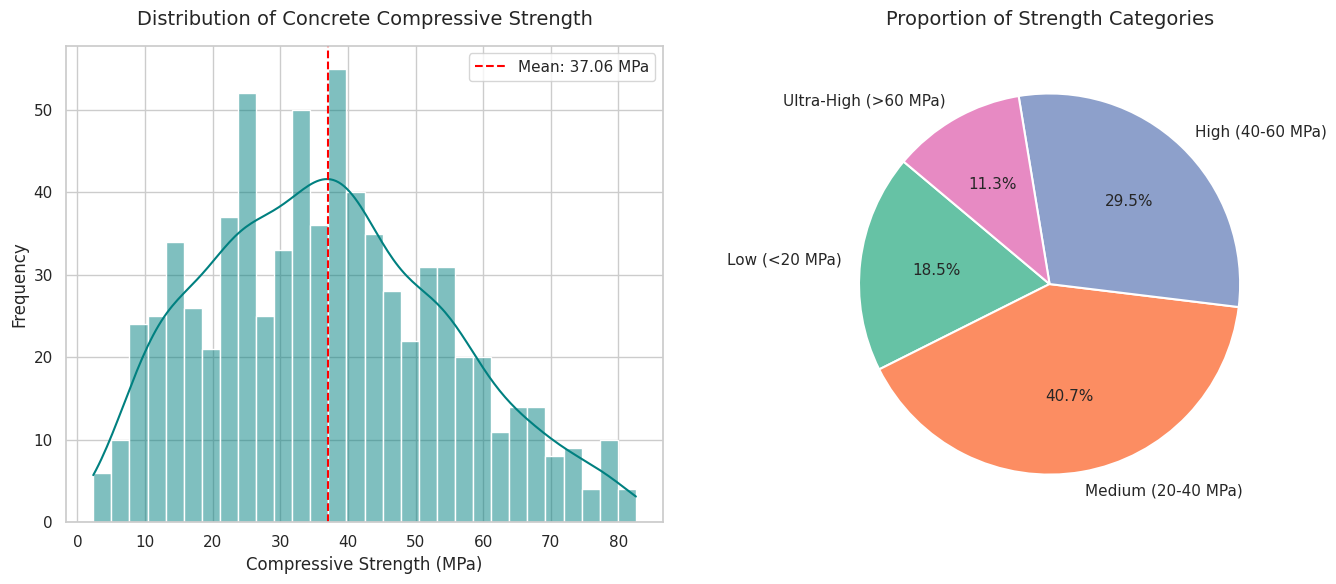

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (移除中文字体依赖，直接使用默认英文)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid") # 添加一个好看的seaborn默认主题

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 3. 绘制并排双图 (1行2列)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------------------------
# 图 1 (左)：数值分布图 (Histogram + KDE)
# ------------------------------------------
sns.histplot(train[target_col], bins=30, kde=True, color='teal', edgecolor='white', ax=axes[0])
axes[0].set_title('Distribution of Concrete Compressive Strength', fontsize=14, pad=15)
axes[0].set_xlabel('Compressive Strength (MPa)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

mean_val = train[target_col].mean()
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f} MPa')
axes[0].legend()

# ------------------------------------------
# 图 2 (右)：分布占比图 (Pie Chart)
# ------------------------------------------
bins = [0, 20, 40, 60, 100]  
labels = ['Low (<20 MPa)', 'Medium (20-40 MPa)', 'High (40-60 MPa)', 'Ultra-High (>60 MPa)']

strength_cats = pd.cut(train[target_col], bins=bins, labels=labels)
cat_counts = strength_cats.value_counts(sort=False)

colors = sns.color_palette('Set2') 
axes[1].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=140, 
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
            textprops={'fontsize': 11})
axes[1].set_title('Proportion of Strength Categories', fontsize=14, pad=15)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout()
plt.savefig('strength_distribution_and_pie_english.png', dpi=300)
plt.show()

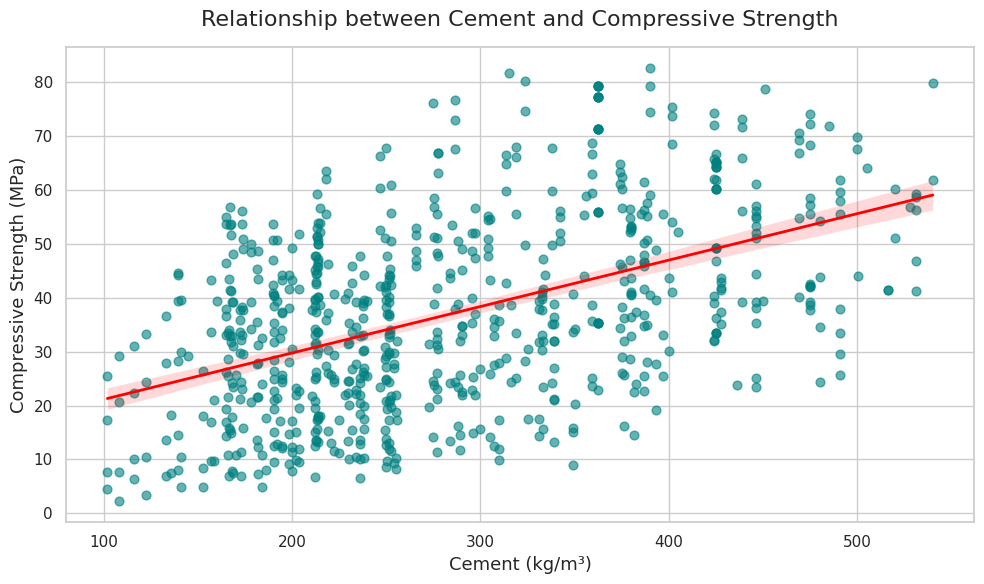

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (使用英文避免字体报错，设置白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# ==========================================
# 3. 绘制带有回归趋势线的散点图
# ==========================================
plt.figure(figsize=(10, 6))

# 使用 seaborn 的 regplot 绘制散点 + 回归线
sns.regplot(
    x='Cement', 
    y='Concrete compressive strength', 
    data=train, 
    scatter_kws={'alpha': 0.6, 'color': 'teal', 's': 40}, # 散点设置：半透明、蓝绿色、大小为40
    line_kws={'color': 'red', 'linewidth': 2}             # 回归线设置：红色、加粗
)

# ==========================================
# 4. 设置标题与坐标轴标签
# ==========================================
plt.title('Relationship between Cement and Compressive Strength', fontsize=16, pad=15)
plt.xlabel('Cement (kg/m³)', fontsize=13)
plt.ylabel('Compressive Strength (MPa)', fontsize=13)

# ==========================================
# 5. 保存图片并展示
# ==========================================
plt.tight_layout()
plt.savefig('cement_vs_strength.png', dpi=300) # 保存为高清图片
plt.show()

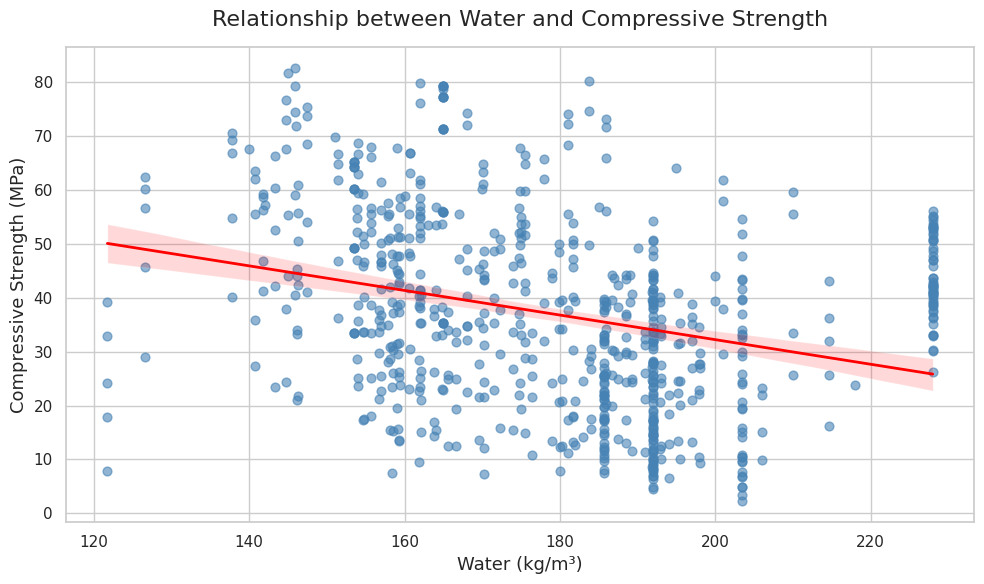

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# ==========================================
# 3. 绘制带有回归趋势线的散点图 (Water vs Strength)
# ==========================================
plt.figure(figsize=(10, 6))

# 绘制散点与回归线
sns.regplot(
    x='Water', 
    y='Concrete compressive strength', 
    data=train, 
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 40}, # 散点设置：半透明、钢蓝色
    line_kws={'color': 'red', 'linewidth': 2}                   # 回归线设置：红色、加粗
)

# ==========================================
# 4. 设置标题与坐标轴标签
# ==========================================
plt.title('Relationship between Water and Compressive Strength', fontsize=16, pad=15)
plt.xlabel('Water (kg/m³)', fontsize=13)
plt.ylabel('Compressive Strength (MPa)', fontsize=13)

# ==========================================
# 5. 保存并展示图片
# ==========================================
plt.tight_layout()
plt.savefig('water_vs_strength.png', dpi=300)
plt.show()

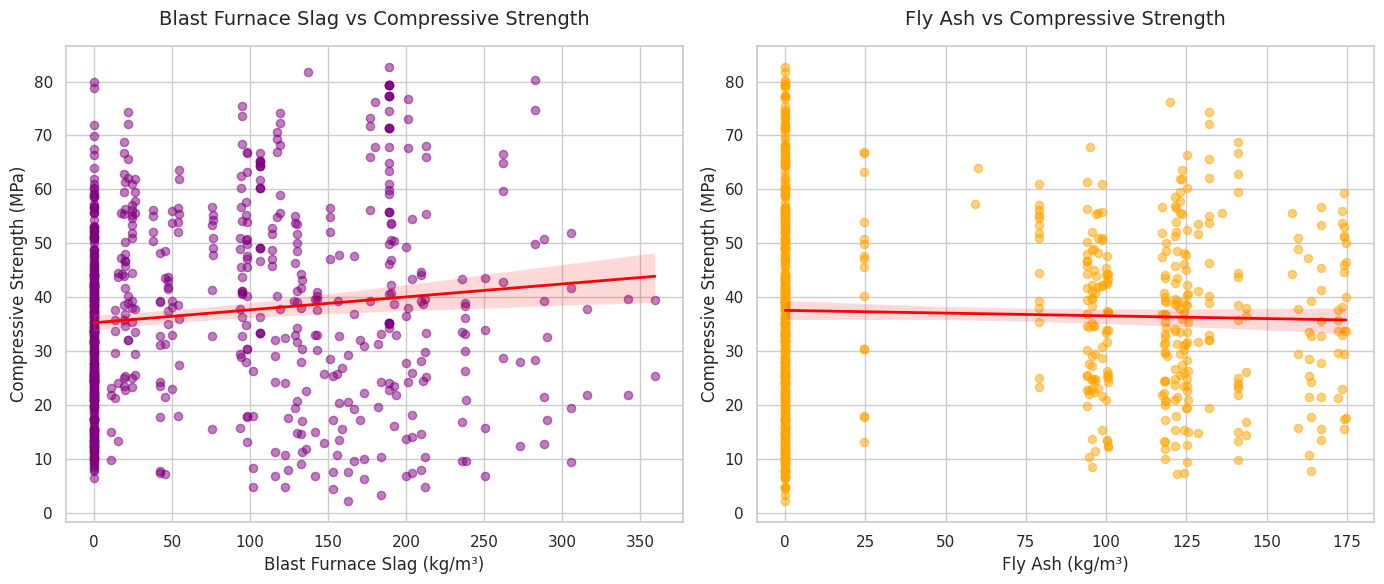

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 3. 绘制并排双图 (1行2列)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------------------------
# 图 1 (左)：Blast Furnace Slag vs 强度
# ------------------------------------------
sns.regplot(
    x='Blast Furnace Slag', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'purple', 's': 35}, 
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[0]
)
axes[0].set_title('Blast Furnace Slag vs Compressive Strength', fontsize=14, pad=15)
axes[0].set_xlabel('Blast Furnace Slag (kg/m³)', fontsize=12)
axes[0].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ------------------------------------------
# 图 2 (右)：Fly Ash vs 强度
# ------------------------------------------
sns.regplot(
    x='Fly Ash', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'orange', 's': 35}, 
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[1]
)
axes[1].set_title('Fly Ash vs Compressive Strength', fontsize=14, pad=15)
axes[1].set_xlabel('Fly Ash (kg/m³)', fontsize=12)
axes[1].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout()
plt.savefig('slag_flyash_vs_strength.png', dpi=300)
plt.show()

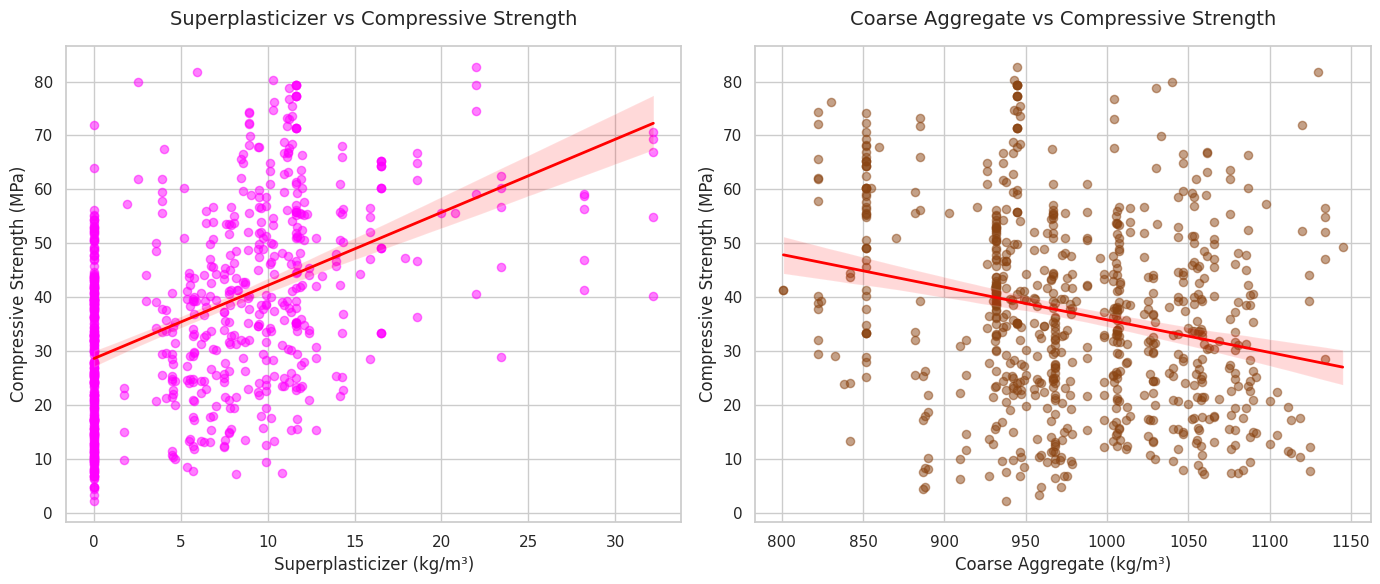

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 3. 绘制并排双图 (1行2列)
# ==========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------------------------
# 图 1 (左)：Superplasticizer (减水剂) vs 强度
# ------------------------------------------
sns.regplot(
    x='Superplasticizer', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'magenta', 's': 35}, # 散点：品红色
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[0]
)
axes[0].set_title('Superplasticizer vs Compressive Strength', fontsize=14, pad=15)
axes[0].set_xlabel('Superplasticizer (kg/m³)', fontsize=12)
axes[0].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ------------------------------------------
# 图 2 (右)：Coarse Aggregate (粗骨料) vs 强度
# ------------------------------------------
sns.regplot(
    x='Coarse Aggregate', 
    y=target_col, 
    data=train, 
    scatter_kws={'alpha': 0.5, 'color': 'saddlebrown', 's': 35}, # 散点：棕褐色
    line_kws={'color': 'red', 'linewidth': 2},
    ax=axes[1]
)
axes[1].set_title('Coarse Aggregate vs Compressive Strength', fontsize=14, pad=15)
axes[1].set_xlabel('Coarse Aggregate (kg/m³)', fontsize=12)
axes[1].set_ylabel('Compressive Strength (MPa)', fontsize=12)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout()
plt.savefig('superplasticizer_coarse_vs_strength.png', dpi=300)
plt.show()

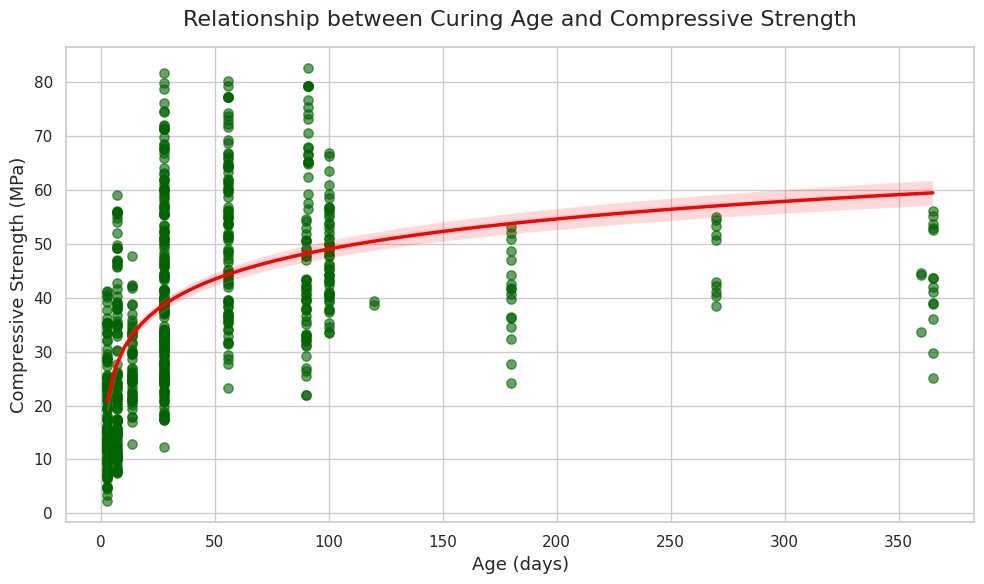

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# ==========================================
# 3. 绘制带有对数回归趋势线的散点图 (Age vs Strength)
# ==========================================
plt.figure(figsize=(10, 6))

# 绘制散点与对数回归线 (logx=True 完美契合混凝土强度随时间增长的对数规律)
sns.regplot(
    x='Age (day)', 
    y='Concrete compressive strength', 
    data=train, 
    logx=True,                                          # 开启对数回归拟合
    scatter_kws={'alpha': 0.6, 'color': 'darkgreen', 's': 45}, # 散点：深绿色
    line_kws={'color': 'red', 'linewidth': 2.5}         # 回归线：红色、加粗
)

# ==========================================
# 4. 设置标题与坐标轴标签
# ==========================================
plt.title('Relationship between Curing Age and Compressive Strength', fontsize=16, pad=15)
plt.xlabel('Age (days)', fontsize=13)
plt.ylabel('Compressive Strength (MPa)', fontsize=13)

# 设置横坐标为对数刻度（可选，能更清晰地看清早期数据，这里我们保持常规线性刻度以直观感受长尾效应）
# plt.xscale('log') 

# ==========================================
# 5. 保存并展示图片
# ==========================================
plt.tight_layout()
plt.savefig('age_vs_strength.png', dpi=300)
plt.show()

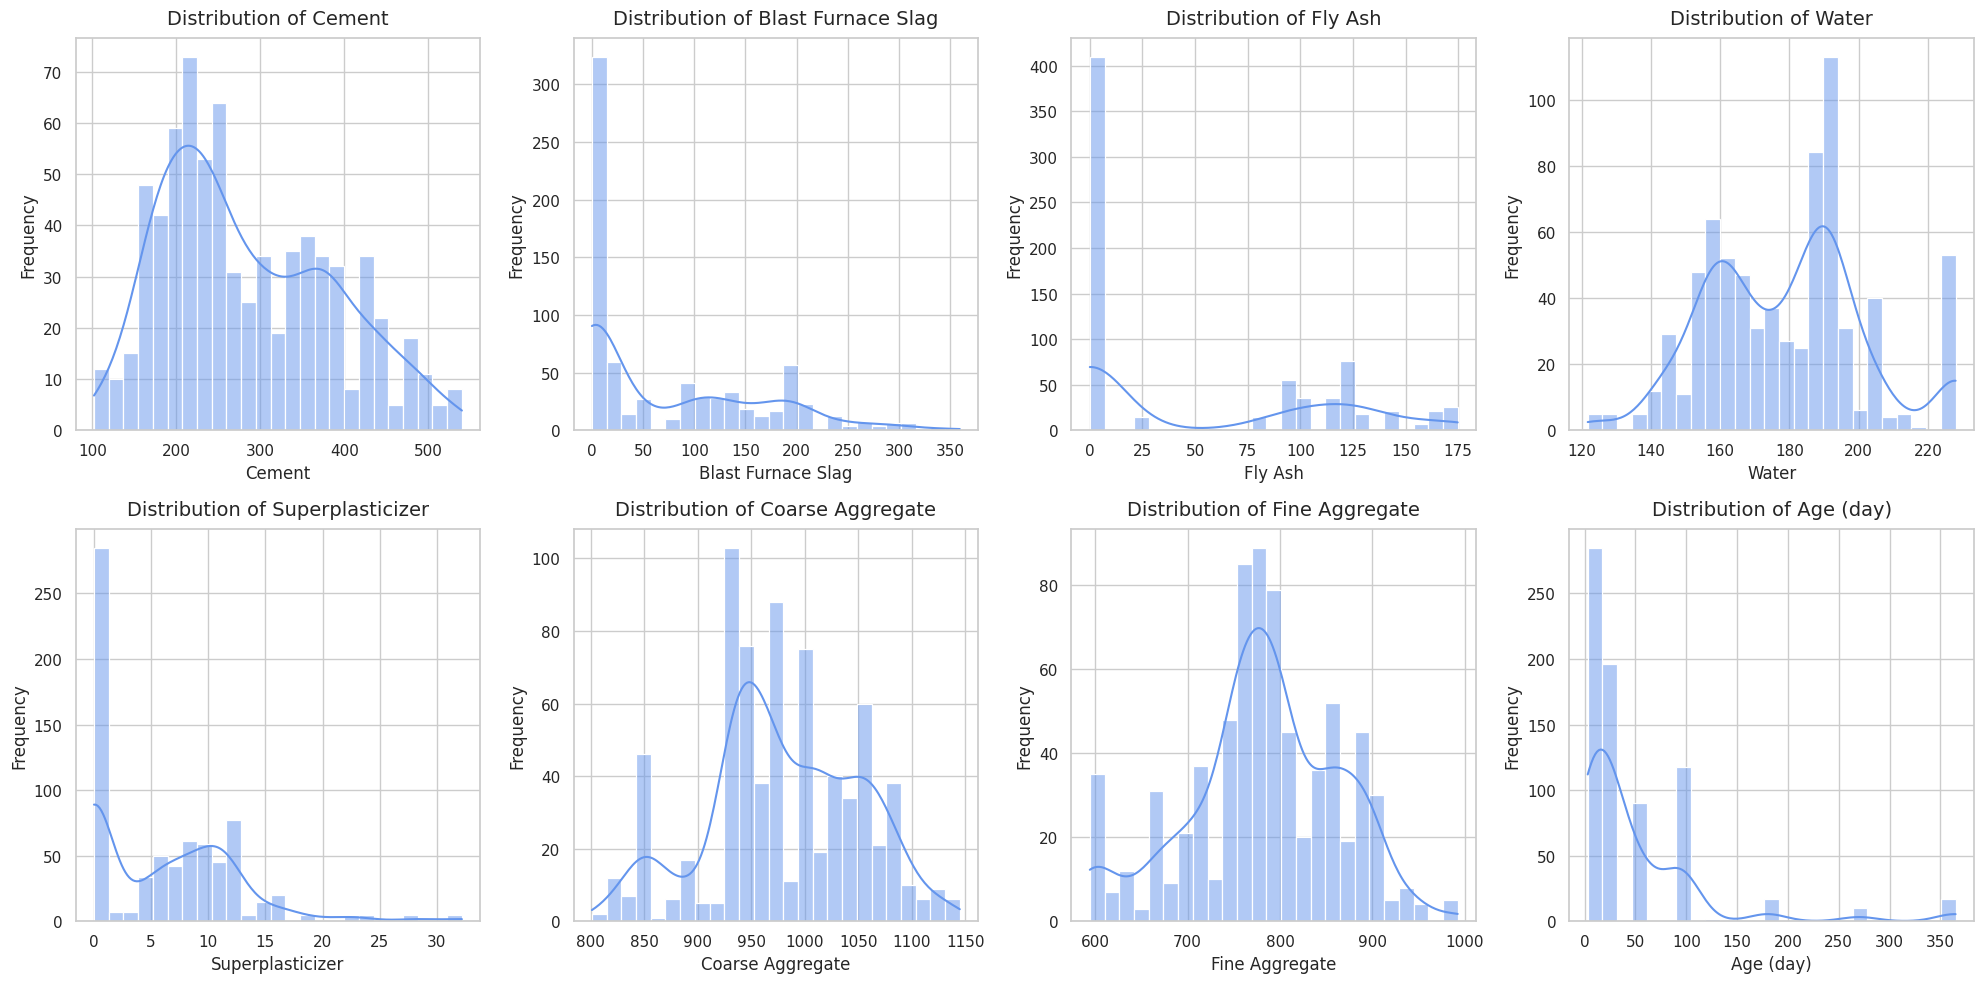

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 基础设置 (英文环境、白底网格主题)
# ==========================================
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid")

# ==========================================
# 2. 读取数据并提取 8 个特征列
# ==========================================
train = pd.read_csv('train.csv')
train.columns = train.columns.str.strip()

# 把目标变量排除，剩下的 8 个全都是我们要画的特征
target_col = 'Concrete compressive strength'
features = [col for col in train.columns if col != target_col]

# ==========================================
# 3. 绘制 2 行 4 列的直方图矩阵
# ==========================================
fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # 创建一个 20x10 英寸的大画布
axes = axes.flatten() # 将 2x4 的矩阵展平，方便我们用 for 循环遍历

# 给直方图挑一个好看的颜色
plot_color = 'cornflowerblue'

# 遍历 8 个特征，逐一画图
for i, feature in enumerate(features):
    sns.histplot(
        train[feature], 
        bins=25,          # 柱子的数量
        kde=True,         # 开启核密度估计曲线
        color=plot_color, 
        edgecolor='white',
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature}', fontsize=14, pad=10)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# ==========================================
# 4. 显示并保存图片
# ==========================================
plt.tight_layout() # 自动调整子图间距，防止文字重叠
plt.savefig('8_features_histograms.png', dpi=300) # 保存为高清图片
plt.show()

# <a id='toc5_'></a>[工具函数](#toc0_)

In [13]:
def f1_best_threshold(y_true, y_prob):
    """返回最大化 F1 的阈值与对应 F1"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx], f1s[best_idx]



# <a id='toc6_'></a>[数据预处理](#toc0_)


功能：处理数据中的缺失值和异常值，同时记录异常/缺失标记，为建模做准备

In [14]:
import pandas as pd
import numpy as np

# ==========================================
# 1. 读取数据
# ==========================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

target_col = 'Concrete compressive strength'

# 提取需要处理的特征列
features = [col for col in train.columns if col != target_col]

# 为了防止修改原始数据，我们创建副本
train_processed = train.copy()
test_processed = test.copy()

# ==========================================
# 2. 缺失值处理与标记 (Missing Value Imputation & Flagging)
# ==========================================
print("正在检测并处理缺失值...")
for col in features:
    # 检查训练集中是否有缺失值
    if train_processed[col].isnull().any() or test_processed[col].isnull().any():
        # 记录缺失标记 (1表示缺失，0表示正常)
        train_processed[f'{col}_is_missing'] = train_processed[col].isnull().astype(int)
        test_processed[f'{col}_is_missing'] = test_processed[col].isnull().astype(int)
        
        # 使用训练集的中位数来填充 (中位数对异常值更鲁棒)
        median_val = train_processed[col].median()
        train_processed[col].fillna(median_val, inplace=True)
        test_processed[col].fillna(median_val, inplace=True)
        print(f"  - 特征 '{col}' 存在缺失，已使用中位数 {median_val:.2f} 填充并添加标记。")

# ==========================================
# 3. 异常值处理与标记 (Outlier Clipping & Flagging using IQR)
# ==========================================
print("\n正在检测并处理异常值 (IQR 方法)...")
for col in features:
    # 只使用训练集计算 IQR (四分位距) 和上下界
    Q1 = train_processed[col].quantile(0.25)
    Q3 = train_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # 定义异常值的上下限边界 (通常为 1.5 倍的 IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 记录异常标记 (超出边界的设为 1，否则为 0)
    train_processed[f'{col}_is_outlier'] = ((train_processed[col] < lower_bound) | (train_processed[col] > upper_bound)).astype(int)
    test_processed[f'{col}_is_outlier'] = ((test_processed[col] < lower_bound) | (test_processed[col] > upper_bound)).astype(int)
    
    outlier_count_train = train_processed[f'{col}_is_outlier'].sum()
    if outlier_count_train > 0:
        print(f"  - 特征 '{col}' 检测到 {outlier_count_train} 个异常值。已添加异常标记。")
        
    # 对异常值进行“盖帽”处理 (Clipping)
    # 将小于下界的值强制设为下界，大于上界的值强制设为上界
    train_processed[col] = train_processed[col].clip(lower=lower_bound, upper=upper_bound)
    test_processed[col] = test_processed[col].clip(lower=lower_bound, upper=upper_bound)

# ==========================================
# 4. 预览与保存处理后的数据
# ==========================================
# 重新将目标变量放回训练集
train_processed[target_col] = train[target_col]

# 保存清洗和提取标记后的数据，供后续建模使用
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

print("\n🎉 数据处理完成！")
print(f"训练集特征维度从 {train.shape[1]-1} 扩展到了 {train_processed.shape[1]-1} (包含新生成的标记列)。")
print("已保存为 'train_processed.csv' 和 'test_processed.csv'")

# 打印出新增的列名看看
new_cols = [col for col in train_processed.columns if 'is_outlier' in col or 'is_missing' in col]
print("\n新增的标记特征列如下：")
print(new_cols)

正在检测并处理缺失值...

正在检测并处理异常值 (IQR 方法)...
  - 特征 'Blast Furnace Slag' 检测到 4 个异常值。已添加异常标记。
  - 特征 'Superplasticizer' 检测到 10 个异常值。已添加异常标记。
  - 特征 'Fine Aggregate' 检测到 35 个异常值。已添加异常标记。
  - 特征 'Age (day)' 检测到 44 个异常值。已添加异常标记。

🎉 数据处理完成！
训练集特征维度从 8 扩展到了 16 (包含新生成的标记列)。
已保存为 'train_processed.csv' 和 'test_processed.csv'

新增的标记特征列如下：
['Cement_is_outlier', 'Blast Furnace Slag_is_outlier', 'Fly Ash_is_outlier', 'Water_is_outlier', 'Superplasticizer_is_outlier', 'Coarse Aggregate_is_outlier', 'Fine Aggregate_is_outlier', 'Age (day)_is_outlier']


# <a id='toc7_'></a>[特征工程](#toc0_)

1. **类别特征编码处理**  
   对贷款期限（Term）二值化、工作年限（Years in current job）有序编码、住房所有权（Home Ownership）独热编码，同时对贷款用途（Purpose）等做频数编码，将非数值类别特征转化为模型可使用的格式。

2. **数值特征优化转换**  
   按标准区间对信用评分（Credit Score）分箱并填充缺失值，对年收入、贷款金额等数值特征做对数变换，缓解数据偏度，提升数值特征对模型的适配性。

3. **关键新特征构建**  
   计算债务比率、信贷利用率等财务比例特征，生成“贷款用途-期限”类别交互特征，挖掘数据中隐藏的指标关联与组合效应，丰富特征维度。

4. **数据安全与完整性保障**  
   复制原始数据避免修改，通过条件判断确保特征存在再处理，将计算中出现的无穷值替换为缺失值，保障特征工程过程中数据的安全性与有效性。

In [15]:
import pandas as pd
import numpy as np

# ==========================================
# 0. 数据加载与安全准备
# ==========================================
print("=== 开始执行高级特征工程 ===")
# 使用上一步处理好的、没有缺失和异常的数据
train = pd.read_csv('train_processed.csv')
test = pd.read_csv('test_processed.csv')

# 【4. 数据安全与完整性保障】: 复制原始数据避免修改原始引用
train_fe = train.copy()
test_fe = test.copy()

target_col = 'Concrete compressive strength'

# ==========================================
# 1. 关键新特征构建 (业务驱动的衍生)
# ==========================================
print("\n[1/4] 正在构建关键材料学交互特征...")
def create_business_features(df):
    # 确保特征存在再处理 (数据安全保障)
    if all(col in df.columns for col in ['Cement', 'Water']):
        df['Water_Cement_Ratio'] = df['Water'] / (df['Cement'] + 1e-8) # 加1e-8防止分母为0
    
    if all(col in df.columns for col in ['Cement', 'Blast Furnace Slag', 'Fly Ash']):
        # 总胶凝材料 (胶结物总和)
        df['Total_Binder'] = df['Cement'] + df['Blast Furnace Slag'] + df['Fly Ash']
        # 水胶比 (现代混凝土比水灰比更核心的指标)
        df['Water_Binder_Ratio'] = df['Water'] / (df['Total_Binder'] + 1e-8)
        
    if all(col in df.columns for col in ['Coarse Aggregate', 'Fine Aggregate']):
        # 砂率 (细骨料占总骨料的比例)
        df['Sand_Ratio'] = df['Fine Aggregate'] / (df['Coarse Aggregate'] + df['Fine Aggregate'] + 1e-8)
        
    return df

train_fe = create_business_features(train_fe)
test_fe = create_business_features(test_fe)

# ==========================================
# 2. 类别特征编码处理
# ==========================================
print("[2/4] 正在进行类别特征衍生与编码...")
# 2.1 二值化特征 (Binarization): 是否添加了某种外加剂/掺合料
for df in [train_fe, test_fe]:
    if 'Superplasticizer' in df.columns:
        df['has_Superplasticizer'] = (df['Superplasticizer'] > 0).astype(int)
    if 'Fly Ash' in df.columns:
        df['has_FlyAsh'] = (df['Fly Ash'] > 0).astype(int)

# 2.2 离散化与有序编码 (Ordinal Encoding): 将连续的养护龄期分箱为类别
bins_age = [-1, 7, 28, 90, 1000] # 早期、标准期、后期、超后期
labels_age = [0, 1, 2, 3] # 有序类别
for df in [train_fe, test_fe]:
    if 'Age (day)' in df.columns:
        df['Age_Phase_Ordinal'] = pd.cut(df['Age (day)'], bins=bins_age, labels=labels_age).astype(float)

# 2.3 独热编码 (One-Hot Encoding): 为 Age Phase 生成独热向量
train_fe = pd.get_dummies(train_fe, columns=['Age_Phase_Ordinal'], prefix='Age_Phase_OHE', drop_first=False)
test_fe = pd.get_dummies(test_fe, columns=['Age_Phase_Ordinal'], prefix='Age_Phase_OHE', drop_first=False)

# 2.4 频数编码 (Frequency Encoding): 计算某种配比类型在训练集中出现的频率
# 假设我们把"是否加减水剂+是否加粉煤灰"作为一个组合类别
train_fe['mix_type'] = train_fe['has_Superplasticizer'].astype(str) + "_" + train_fe['has_FlyAsh'].astype(str)
test_fe['mix_type'] = test_fe['has_Superplasticizer'].astype(str) + "_" + test_fe['has_FlyAsh'].astype(str)

freq_map = train_fe['mix_type'].value_counts(normalize=True).to_dict() # 仅用训练集计算频率，防止穿越
train_fe['mix_type_freq'] = train_fe['mix_type'].map(freq_map)
test_fe['mix_type_freq'] = test_fe['mix_type'].map(freq_map).fillna(0) # 测试集如果出现没见过的组合，填0

# 删掉作为中间桥梁的字符列
train_fe.drop(columns=['mix_type'], inplace=True)
test_fe.drop(columns=['mix_type'], inplace=True)

# ==========================================
# 3. 数值特征优化转换
# ==========================================
print("[3/4] 正在进行数值特征偏度优化与目标分箱...")
# 3.1 对高度右偏的数值特征进行对数平滑转换 (缓解长尾效应)
# 使用 np.log1p(x) = log(x+1)，能完美兼容值为 0 的特征
skewed_cols = ['Age (day)', 'Superplasticizer', 'Fly Ash', 'Blast Furnace Slag']
for col in skewed_cols:
    if col in train_fe.columns:
        train_fe[f'{col}_log1p'] = np.log1p(train_fe[col])
        test_fe[f'{col}_log1p'] = np.log1p(test_fe[col])

# 3.2 对目标变量进行标准区间分箱并填充缺失值 (仅限训练集)
if target_col in train_fe.columns:
    # 按照土木工程强度等级分箱: 低于C30, C30-C50, 高于C50
    bins_target = [0, 30, 50, 200]
    labels_target = [0, 1, 2]
    train_fe['Strength_Level'] = pd.cut(train_fe[target_col], bins=bins_target, labels=labels_target)
    # 填充缺失值 (以防有极其异常的值没被划分进去)
    train_fe['Strength_Level'] = train_fe['Strength_Level'].fillna(train_fe['Strength_Level'].mode()[0]).astype(int)

# ==========================================
# 4. 数据安全与完整性保障 (兜底处理)
# ==========================================
print("[4/4] 正在执行数据安全校验(Inf/NaN 兜底)...")
# 在除法运算中极大概率产生无穷大值 (Infinity)，将其替换为空值，再用0填补
train_fe.replace([np.inf, -np.inf], np.nan, inplace=True)
test_fe.replace([np.inf, -np.inf], np.nan, inplace=True)

train_fe.fillna(0, inplace=True)
test_fe.fillna(0, inplace=True)

# 确保训练集和测试集的特征列顺序和数量完全一致（除目标变量外）
# 这是模型上线预测时不报错的最核心保障！
align_cols = [col for col in train_fe.columns if col not in [target_col, 'Strength_Level']]
X_train_final = train_fe[align_cols]
X_test_final = test_fe[align_cols]
y_train_final = train_fe[target_col]

# 保存最终喂给模型的数据
train_fe.to_csv('train_fe_final.csv', index=False)
test_fe.to_csv('test_fe_final.csv', index=False)

print("\n🎉 特征工程全部完成！")
print(f"经过多维度挖掘，特征数量从原始的 {train.shape[1]-1} 个爆炸式提升至 {X_train_final.shape[1]} 个！")
print("数据已保存为 'train_fe_final.csv' 和 'test_fe_final.csv'，完美适配所有树模型与线性模型！")

=== 开始执行高级特征工程 ===

[1/4] 正在构建关键材料学交互特征...
[2/4] 正在进行类别特征衍生与编码...
[3/4] 正在进行数值特征偏度优化与目标分箱...
[4/4] 正在执行数据安全校验(Inf/NaN 兜底)...

🎉 特征工程全部完成！
经过多维度挖掘，特征数量从原始的 16 个爆炸式提升至 31 个！
数据已保存为 'train_fe_final.csv' 和 'test_fe_final.csv'，完美适配所有树模型与线性模型！


1. 从训练数据中分离目标变量（转为整数）和特征数据，复制测试数据。
2. 用训练特征拟合预处理模型，再分别对训练和测试特征做预处理。
3. 通过特征生成器对预处理后的训练、测试特征进行特征工程，确保处理一致性，为建模做准备。

In [16]:
import pandas as pd
import numpy as np

# ==========================================
# 0. 读取数据
# ==========================================
print("=== 开始执行标准化特征工程 Pipeline ===")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 清理列名以防隐藏空格
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()
target_col = 'Concrete compressive strength'

# ==========================================
# 步骤 1: 分离目标变量（转为整数）和特征数据，复制测试数据
# ==========================================
# 提取目标变量，并严格按照要求转换为整数类型 (int)
y_train = train[target_col].astype(int)

# 提取特征数据 (复制以防修改原数据)
X_train = train.drop(columns=[target_col]).copy()

# 复制测试数据 (假设测试集中若存在目标列则剔除它)
if target_col in test.columns:
    X_test = test.drop(columns=[target_col]).copy()
else:
    X_test = test.copy()

print(f"[1/3] 步骤 1 完成：\n - X_train 维度: {X_train.shape}, y_train 维度: {y_train.shape}\n - X_test 维度: {X_test.shape}")

# ==========================================
# 步骤 2: 用训练特征拟合预处理模型，再分别对训练和测试特征做预处理
# ==========================================
class DataPreprocessor:
    def __init__(self):
        self.medians = {}
        self.iqr_bounds = {}
        self.features = []
        
    def fit(self, X):
        """只用训练集 (X) 的特征拟合模型，记录中位数和异常边界"""
        self.features = X.columns.tolist()
        for col in self.features:
            self.medians[col] = X[col].median()
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            # 记录 IQR 异常值盖帽的上下界
            self.iqr_bounds[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self
        
    def transform(self, X):
        """将记录的规则应用到训练集和测试集上"""
        X_out = X.copy()
        for col in self.features:
            if col in X_out.columns:
                # 缺失值填充
                X_out[col] = X_out[col].fillna(self.medians[col])
                
                # 异常值盖帽 (Clipping)
                lower, upper = self.iqr_bounds[col]
                X_out[col] = X_out[col].clip(lower=lower, upper=upper)
        return X_out

# 实例化、拟合并进行转换
preprocessor = DataPreprocessor()
preprocessor.fit(X_train) # 仅用训练集拟合
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print(f"\n[2/3] 步骤 2 完成：预处理模型拟合与转换完毕。\n - 预处理后的 X_train_prep 维度: {X_train_prep.shape}")

# ==========================================
# 步骤 3: 通过特征生成器对预处理后的特征进行特征工程，确保处理一致性
# ==========================================
class FeatureGenerator:
    def __init__(self):
        self.freq_map = {}
        
    def fit(self, X):
        """基于训练特征计算频数编码等统计特征，防止数据穿越"""
        has_sp = (X['Superplasticizer'] > 0).astype(int)
        has_fa = (X['Fly Ash'] > 0).astype(int)
        mix_type = has_sp.astype(str) + "_" + has_fa.astype(str)
        # 计算特定组合出现的频率
        self.freq_map = mix_type.value_counts(normalize=True).to_dict()
        return self
        
    def transform(self, X):
        """执行特征工程并生成新特征"""
        df = X.copy()
        
        # 1. 关键新特征构建 (土木材料学比例特征)
        if all(col in df.columns for col in ['Cement', 'Blast Furnace Slag', 'Fly Ash']):
            df['Total_Binder'] = df['Cement'] + df['Blast Furnace Slag'] + df['Fly Ash']
            df['Water_Binder_Ratio'] = df['Water'] / (df['Total_Binder'] + 1e-8)
            
        if all(col in df.columns for col in ['Coarse Aggregate', 'Fine Aggregate']):
            df['Sand_Ratio'] = df['Fine Aggregate'] / (df['Coarse Aggregate'] + df['Fine Aggregate'] + 1e-8)
            
        # 2. 类别特征二值化
        df['has_Superplasticizer'] = (df['Superplasticizer'] > 0).astype(int)
        df['has_FlyAsh'] = (df['Fly Ash'] > 0).astype(int)
        
        # 3. 类别特征有序编码与独热编码
        bins_age = [-1, 7, 28, 90, 1000]
        labels_age = [0, 1, 2, 3]
        if 'Age (day)' in df.columns:
            df['Age_Phase_Ordinal'] = pd.cut(df['Age (day)'], bins=bins_age, labels=labels_age).astype(float)
            df = pd.get_dummies(df, columns=['Age_Phase_Ordinal'], prefix='Age_Phase_OHE', drop_first=False)
            
        # 4. 类别特征频数编码
        mix_type = df['has_Superplasticizer'].astype(str) + "_" + df['has_FlyAsh'].astype(str)
        df['mix_type_freq'] = mix_type.map(self.freq_map).fillna(0)
        
        # 5. 数值特征优化转换 (对数变换，缓解偏度)
        skewed_cols = ['Age (day)', 'Superplasticizer', 'Fly Ash', 'Blast Furnace Slag']
        for col in skewed_cols:
            if col in df.columns:
                df[f'{col}_log1p'] = np.log1p(df[col])
                
        # 6. 数据安全兜底处理 (极其重要)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace=True)
        
        return df

# 实例化特征生成器、拟合并确保处理一致性
feat_gen = FeatureGenerator()
feat_gen.fit(X_train_prep) # 仅用预处理后的训练特征拟合
X_train_final = feat_gen.transform(X_train_prep)
X_test_final = feat_gen.transform(X_test_prep)

# 确保训练集和测试集的特征列顺序和数量绝对一致
align_cols = X_train_final.columns.tolist()
for col in align_cols:
    if col not in X_test_final.columns:
        X_test_final[col] = 0 # 填补测试集没有生成的独热编码列
X_test_final = X_test_final[align_cols] # 保证特征顺序严格对齐

print(f"\n[3/3] 步骤 3 完成：特征工程已一致性执行。\n - 最终 X_train_final 维度: {X_train_final.shape}\n - 最终 X_test_final 维度: {X_test_final.shape}")

# 保存最终可以直接喂给模型的数据
X_train_final.to_csv('X_train_final.csv', index=False)
y_train.to_csv('y_train_final.csv', index=False)
X_test_final.to_csv('X_test_final.csv', index=False)
print("\n🎉 全部就绪！数据已保存为 CSV 文件，随时可以开启建模预测！")



=== 开始执行标准化特征工程 Pipeline ===
[1/3] 步骤 1 完成：
 - X_train 维度: (735, 8), y_train 维度: (735,)
 - X_test 维度: (295, 8)

[2/3] 步骤 2 完成：预处理模型拟合与转换完毕。
 - 预处理后的 X_train_prep 维度: (735, 8)

[3/3] 步骤 3 完成：特征工程已一致性执行。
 - 最终 X_train_final 维度: (735, 22)
 - 最终 X_test_final 维度: (295, 22)

🎉 全部就绪！数据已保存为 CSV 文件，随时可以开启建模预测！


1. 精准划分特征类型
2. 为不同特征类型构建专属处理管道
3. 整合列转换器与应用完整处理流程

In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, KBinsDiscretizer

# ==========================================
# 0. 数据加载与基础准备
# ==========================================
print("=== 构建工业级数据预处理流水线 ===")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()
target_col = 'Concrete compressive strength'

X_train = train.drop(columns=[target_col])
y_train = train[target_col]
# 测试集如果不含标签列，直接复制
X_test = test.drop(columns=[target_col]) if target_col in test.columns else test.copy()

# ==========================================
# 1. 精准划分特征类型 (Feature Categorization)
# ==========================================
# 根据前期的 EDA 探索，我们将特征精准划分为三大类：
# A. 偏态数值特征：存在长尾分布，需要进行对数平滑
skewed_features = ['Age (day)', 'Superplasticizer', 'Fly Ash', 'Blast Furnace Slag']

# B. 正常数值特征：近似正态分布，只需做常规标准化
normal_features = ['Cement', 'Water', 'Coarse Aggregate', 'Fine Aggregate']

# C. 需要进行类别离散化的特征：将连续的龄期强行划分为几个离散的时间阶段(如早期、后期)
category_features = ['Age (day)'] 

print(f"[1/3] 特征划分完毕：\n - 偏态特征: {len(skewed_features)}个\n - 正常特征: {len(normal_features)}个\n - 待离散化类别特征: {len(category_features)}个")

# ==========================================
# 2. 为不同特征类型构建专属处理管道 (Build Pipelines)
# ==========================================
# 自定义对数转换器 (使用 np.log1p 防止 log(0) 报错)
log1p_transformer = FunctionTransformer(np.log1p, validate=False)

# 管道 A：偏态特征处理管道 (中位数填充 -> 对数平滑 -> 标准化)
skewed_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('log', log1p_transformer),
    ('scaler', StandardScaler())
])

# 管道 B：正常特征处理管道 (中位数填充 -> 标准化)
normal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 管道 C：类别分箱管道 (中位数填充 -> 分位数分箱并转为独热编码)
category_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('binner', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'))
])

print("[2/3] 专属处理管道 (Pipelines) 构建完毕！")

# ==========================================
# 3. 整合列转换器与应用完整处理流程 (Column Transformer)
# ==========================================
# 将上述三个管道像组装流水线一样拼接到 ColumnTransformer 中
preprocessor = ColumnTransformer(
    transformers=[
        ('skewed_pipe', skewed_pipeline, skewed_features),
        ('normal_pipe', normal_pipeline, normal_features),
        ('cat_pipe', category_pipeline, category_features)
    ],
    remainder='drop' # 丢弃没有被指定处理的原始列(因为我们已经处理了所有列)
)

# 在训练集上进行 fit_transform (学习规则并转换)
print("[3/3] 正在应用 ColumnTransformer 到训练集...")
X_train_processed_array = preprocessor.fit_transform(X_train)

# 在测试集上进行严格的 transform (仅应用规则，严禁 fit 防止穿越)
print("      正在应用相同的预处理规则到测试集...")
X_test_processed_array = preprocessor.transform(X_test)

# --- 为了后续查看方便，我们将 Numpy Array 重新转回 Pandas DataFrame ---
# 获取转换后的列名
cat_binner = preprocessor.named_transformers_['cat_pipe'].named_steps['binner']
# 生成分箱后的独热编码列名
cat_feature_names = [f'Age_Phase_{i}' for i in range(cat_binner.n_bins_[0])]
final_columns = skewed_features + normal_features + cat_feature_names

X_train_final = pd.DataFrame(X_train_processed_array, columns=final_columns, index=X_train.index)
X_test_final = pd.DataFrame(X_test_processed_array, columns=final_columns, index=X_test.index)

print("\n🎉 完整处理流程执行成功！")
print(f"原始特征数: {X_train.shape[1]} -> 经过管道处理后特征数: {X_train_final.shape[1]}")
print("\n--- 训练集处理后前 3 行预览 ---")
display(X_train_final.head(3))

=== 构建工业级数据预处理流水线 ===
[1/3] 特征划分完毕：
 - 偏态特征: 4个
 - 正常特征: 4个
 - 待离散化类别特征: 1个
[2/3] 专属处理管道 (Pipelines) 构建完毕！
[3/3] 正在应用 ColumnTransformer 到训练集...
      正在应用相同的预处理规则到测试集...

🎉 完整处理流程执行成功！
原始特征数: 8 -> 经过管道处理后特征数: 12

--- 训练集处理后前 3 行预览 ---


,Age (day),Superplasticizer,Fly Ash,Blast Furnace Slag,Cement,Water,Coarse Aggregate,Fine Aggregate,Age_Phase_0,Age_Phase_1,Age_Phase_2,Age_Phase_3
0,0.131643,-0.142407,-0.885006,-1.112779,2.526257,-0.740472,0.853786,-1.287054,0.0,0.0,1.0,0.0
1,0.131643,-0.142407,-0.885006,-1.112779,2.526257,-0.740472,1.066740,-1.287054,0.0,0.0,1.0,0.0
2,1.959615,-1.206322,-0.885006,0.989208,0.473309,2.157625,-0.679487,-2.283949,0.0,0.0,0.0,1.0


# <a id='toc8_'></a>[贝叶斯优化参数空间](#toc0_)

In [18]:
# 1. 导入必要的回归和优化模块
from sklearn.neural_network import MLPRegressor  # 注意：这里改成了 Regressor！
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# 2. 修改为回归专用的 TunedMLPRegressor 类
class TunedMLPRegressor(MLPRegressor):
    def __init__(self, layer_idx=0, activation='relu', alpha=0.0001, 
                 learning_rate_init=0.001, max_iter=200, early_stopping=False, 
                 random_state=None):
        
        # 必须将参数绑定到 self 上，且名称与 __init__ 参数名完全一致
        self.layer_idx = layer_idx
        self.activation = activation
        self.alpha = alpha
        self.learning_rate_init = learning_rate_init
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.random_state = random_state
        
        # 定义层结构映射
        self.layer_configs = [
            (50,),      # index 0
            (100,),     # index 1
            (50, 50)    # index 2
        ]

        super().__init__(
            hidden_layer_sizes=self.layer_configs[0], 
            activation=activation,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            early_stopping=early_stopping,
            random_state=random_state
        )

    def fit(self, X, y):
        # 关键步骤：每次 fit 前，根据当前的 layer_idx 更新 hidden_layer_sizes
        idx = int(self.layer_idx)
        # 边界保护
        if idx < 0 or idx >= len(self.layer_configs):
            idx = 0
        self.hidden_layer_sizes = self.layer_configs[idx]
        
        return super().fit(X, y)
    
# 3. 将优化函数改为回归版本 (使用 RMSE 评估)
def bayes_opt_serial(model, space, X, y, n_iter=12):
    cv_kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    opt = BayesSearchCV(
        model, space, n_iter=n_iter, cv=cv_kfold, 
        scoring='neg_root_mean_squared_error', # 核心修改：改为回归专属的 RMSE
        random_state=42, n_jobs=1, verbose=0   # 改为单进程
    )
    opt.fit(X, y)
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    return opt.best_estimator_, opt.best_params_

def bayes_opt(model, space, X, y, cv=5, n_iter=15, rnd=42):
    """通用贝叶斯优化 - 回归版"""
    cv_kfold = KFold(n_splits=cv, shuffle=True, random_state=rnd)
    opt = BayesSearchCV(
        model, space, n_iter=n_iter, cv=cv_kfold, 
        scoring='neg_root_mean_squared_error', # 核心修改：改为回归专属的 RMSE
        random_state=rnd, n_jobs=-1, verbose=0
    )
    opt.fit(X, y)
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    return opt.best_estimator_, opt.best_params_

In [19]:
import pandas as pd
import numpy as np
from skopt.space import Real, Integer, Categorical

# ==================================================================
# 0. 强壮的数据加载准备 (彻底解决 NameError 报错)
# ==================================================================
print("正在加载并准备训练数据...")
try:
    # 尝试读取我们之前特征工程处理好的数据 (推荐)
    df_train = pd.read_csv('X_train_final.csv')
    df_y = pd.read_csv('y_train_final.csv')
    X_sample = df_train.values
    
    # 适配 y_train_final.csv 可能有一列（带表头）的情况
    y_sample = df_y.iloc[:, 0].values if len(df_y.columns) > 0 else df_y.values.ravel()
    
    print(f"成功加载特征工程数据！特征维度: {X_sample.shape}, 目标维度: {y_sample.shape}")
except FileNotFoundError:
    print("未找到经过管道处理的 X_train_final.csv。将自动回退读取原始 train.csv...")
    # 如果没找到高级特征文件，自动回退到读取最原始的训练集
    df_train = pd.read_csv('train.csv')
    df_train.columns = df_train.columns.str.strip()
    target_col = 'Concrete compressive strength'
    
    X_sample = df_train.drop(columns=[target_col]).values
    y_sample = df_train[target_col].values
    print(f"成功加载原始数据！特征维度: {X_sample.shape}, 目标维度: {y_sample.shape}")

# ==================================================================
# 以下为回归专用的贝叶斯优化参数空间设定 (不用改动)
# ==================================================================

# 注意：回归问题没有 class_weight，已删除！

lgb_space = {
    'n_estimators': Integer(300, 1500),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(10, 100),
    'reg_alpha': Real(0.1, 1.0),
    'reg_lambda': Real(0.1, 1.0),
}

xgb_space = {
    'n_estimators': Integer(300, 1500),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 0.5),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.1, 1.0),
    'reg_lambda': Real(0.1, 1.0),
}

cat_space = {
    'iterations': Integer(300, 1500),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'depth': Integer(3, 10),
    'l2_leaf_reg': Real(0.1, 10.0),
}

# 1. 岭回归 (Ridge Regression)
ridge_space = {
    'alpha': Real(1e-3, 1e2, prior='log-uniform'), 
    'solver': Categorical(['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']) 
}

# 2. 支持向量回归 (SVR)
svr_space = {
    'C': Real(1e-3, 1e2, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf']),  
    'gamma': Categorical(['scale', 'auto']),   
    'epsilon': Real(1e-3, 1.0, prior='log-uniform') 
}

# 3. 决策树回归 (Decision Tree Regressor)
dt_space = {
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'criterion': Categorical(['squared_error', 'friedman_mse', 'absolute_error'])
}

# 4. 随机森林回归 (Random Forest Regressor)
rf_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'max_features': Categorical(['sqrt', 'log2', None]), 
    'bootstrap': Categorical([True, False])
}

# 5. 梯度提升树回归 (GBDT - Sklearn原生)
gbdt_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'subsample': Real(0.6, 1.0),
    'min_samples_split': Integer(2, 20)
}

# 6. 贝叶斯岭回归 (Bayesian Ridge)
br_space = {
    'alpha_1': Real(1e-7, 1e-5, prior='log-uniform'),
    'alpha_2': Real(1e-7, 1e-5, prior='log-uniform'),
    'lambda_1': Real(1e-7, 1e-5, prior='log-uniform'),
    'lambda_2': Real(1e-7, 1e-5, prior='log-uniform')
}

# 7. 多层感知机回归 (MLP Regressor)
# 使用我们之前重构的 layer_idx 方法
mlp_space = {
    'layer_idx': Categorical([0, 1, 2]), 
    'activation': Categorical(['tanh', 'relu']),
    'alpha': Real(1e-5, 1e-2, prior='log-uniform'),
    'learning_rate_init': Real(1e-4, 0.01, prior='log-uniform')
}

print("✅ 所有贝叶斯优化参数空间和数据已成功就绪！你可以开始跑训练代码了！")

正在加载并准备训练数据...
成功加载特征工程数据！特征维度: (735, 22), 目标维度: (735,)
✅ 所有贝叶斯优化参数空间和数据已成功就绪！你可以开始跑训练代码了！


In [20]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore') # 忽略满屏的警告信息

# ==========================================
# 引擎 1：多进程极速版 (适用于 Ridge, SVR, 决策树等基础模型)
# ==========================================
def bayes_opt(model, space, X, y, n_iter=12):
    """
    通用回归任务贝叶斯优化函数（多进程加速）
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=space,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_root_mean_squared_error',  
        n_jobs=-1, # <--- 开启所有 CPU 核心并行搜索
        random_state=42,
        verbose=0
    )
    opt.fit(X, y)
    
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    print(f"   => 最佳参数: {dict(opt.best_params_)}\n")
    return opt.best_estimator_, opt.best_params_

# ==========================================
# 引擎 2：单进程防崩溃版 (适用于 MLP, XGBoost, CatBoost 等自带并行的模型)
# ==========================================
def bayes_opt_serial(model, space, X, y, n_iter=12):
    """
    针对容易导致线程死锁的复杂模型的优化函数
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=space,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_root_mean_squared_error',  
        n_jobs=1, # <--- 核心修改：改为单进程，让模型内部自己去调度多线程
        random_state=42,
        verbose=0
    )
    opt.fit(X, y)
    
    print(f"   => 最佳验证集 RMSE: {-opt.best_score_:.4f}")
    print(f"   => 最佳参数: {dict(opt.best_params_)}\n")
    return opt.best_estimator_, opt.best_params_

In [21]:
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

class TunedMLPRegressor(MLPRegressor):
    """专门为了绕过 skopt 元组 Bug 而编写的包装类"""
    def __init__(self, layer_idx=0, activation='relu', alpha=0.0001, 
                 learning_rate_init=0.001, max_iter=1000, early_stopping=True, random_state=42):
        self.layer_idx = layer_idx
        hidden_sizes = [(50,), (100,), (50, 50)][layer_idx]
        super().__init__(
            hidden_layer_sizes=hidden_sizes, activation=activation, alpha=alpha, 
            learning_rate_init=learning_rate_init, max_iter=max_iter, 
            early_stopping=early_stopping, random_state=random_state
        )

    def set_params(self, **params):
        if 'layer_idx' in params:
            self.layer_idx = params.pop('layer_idx')
            self.hidden_layer_sizes = [(50,), (100,), (50, 50)][self.layer_idx]
        return super().set_params(**params)

# ==========================================
# 1. 基础模型 (Sklearn) 贝叶斯优化
# ==========================================
print('【1/10 岭回归 (Ridge) 贝叶斯优化】')
ridge_model, ridge_best = bayes_opt(
    Ridge(max_iter=2000, random_state=42), ridge_space, X_sample, y_sample, n_iter=12)

print('【2/10 支持向量回归 (SVR) 贝叶斯优化】')
svm_model, svm_best = bayes_opt(
    SVR(), svr_space, X_sample, y_sample, n_iter=12)

print('【3/10 决策树回归 (DT) 贝叶斯优化】')
dt_model, dt_best = bayes_opt(
    DecisionTreeRegressor(random_state=42), dt_space, X_sample, y_sample, n_iter=12)

print('【4/10 随机森林回归 (RF) 贝叶斯优化】')
rf_model, rf_best = bayes_opt(
    RandomForestRegressor(random_state=42), rf_space, X_sample, y_sample, n_iter=12)

print('【5/10 GBDT回归 贝叶斯优化】')
gbdt_model, gbdt_best = bayes_opt(
    GradientBoostingRegressor(random_state=42), gbdt_space, X_sample, y_sample, n_iter=12)

print('【6/10 贝叶斯岭回归 (Bayesian Ridge) 贝叶斯优化】')
br_model, br_best = bayes_opt(
    BayesianRidge(), br_space, X_sample, y_sample, n_iter=12)

print('【7/10 MLP回归 (神经网络) 贝叶斯优化】')
mlp_model, mlp_best = bayes_opt(
    TunedMLPRegressor(), mlp_space, X_sample, y_sample, n_iter=12)

# ==========================================
# 2. 提升树模型 (Boosting) 贝叶斯优化
# ==========================================
print('【8/10 LightGBM回归 贝叶斯优化】')
# 核心修改：强制 LGBM 内部只使用 1 个线程 (n_jobs=1)，彻底防止底层 C++ 死锁
lgb_model, lgb_best = bayes_opt(
    lgb.LGBMRegressor(random_state=42, verbose=-1, n_jobs=1), 
    lgb_space, X_sample, y_sample, n_iter=12)

print('【9/10 XGBoost回归 贝叶斯优化】')
# 核心修改：加入 n_jobs=1
xgb_model, xgb_best = bayes_opt(
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', tree_method='hist', random_state=42, n_jobs=1), 
    xgb_space, X_sample, y_sample, n_iter=12)

print('【10/10 CatBoost回归 贝叶斯优化】')
# 核心修改：CatBoost 叫 thread_count，设为 1
cat_model, cat_best = bayes_opt(
    cb.CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', random_state=42, verbose=False, thread_count=1), 
    cat_space, X_sample, y_sample, n_iter=12)

print("\n🎉 十大模型贝叶斯调优全部完成！现在你可以去运行下面画图和模型融合的代码了！")

【1/10 岭回归 (Ridge) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.6438
   => 最佳参数: {'alpha': 0.001, 'solver': 'svd'}

【2/10 支持向量回归 (SVR) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.9214
   => 最佳参数: {'C': 1.803702051091432, 'epsilon': 0.9662077968184982, 'gamma': 'scale', 'kernel': 'linear'}

【3/10 决策树回归 (DT) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.2678
   => 最佳参数: {'criterion': 'absolute_error', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 19}

【4/10 随机森林回归 (RF) 贝叶斯优化】
   => 最佳验证集 RMSE: 4.7241
   => 最佳参数: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 396}

【5/10 GBDT回归 贝叶斯优化】
   => 最佳验证集 RMSE: 4.2407
   => 最佳参数: {'learning_rate': 0.07726692534078465, 'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 500, 'subsample': 0.6}

【6/10 贝叶斯岭回归 (Bayesian Ridge) 贝叶斯优化】
   => 最佳验证集 RMSE: 6.7183
   => 最佳参数: {'alpha_1': 8.798902345261948e-06, 'alpha_2': 2.760586704351774e-06, 'lambda_1': 1.0426414561882317e-07, 'lambda_2': 8.417016179442586e-06}

【7/10 MLP回归 (神经网络) 贝叶斯优化】

In [25]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# ------------------------------------------------------------------
# 专门为回归任务定制的 SMOTE 函数
# ------------------------------------------------------------------
def apply_smote_regression(X, y, n_bins=3):
    """
    专门为回归任务定制的 SMOTE 采样函数
    逻辑：先对连续值 y 进行分箱，找出数据稀缺的区间，再进行过采样。
    
    参数:
        X: 特征数据
        y: 连续的标签数据 (如混凝土抗压强度)
        n_bins: 分箱数量。默认分为低、中、高 3 个强度区间
    """
    print(f"   -> 正在准备针对连续变量的回归 SMOTE 采样...")
    
    # 1. 临时分箱：将连续的强度值 y 转化为 n_bins 个离散类别
    # 使用 qcut 进行等频分箱，确保每个箱子里初始都有数据
    # 如果数据极其不平衡，某些极值区间可能样本很少，这正是我们要扩充的
    try:
        y_bins = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')
    except Exception as e:
        print(f"   ⚠️ 分箱失败，可能是数据分布极其特殊。将退回不采样。错误信息: {e}")
        return X, y

    # 2. 检查各类别样本数，确定 SMOTE 的有效近邻数 k
    # 统计每个箱子里的样本数
    unique_bins, counts = np.unique(y_bins, return_counts=True)
    min_samples_in_bin = np.min(counts)
    
    # k_neighbors 必须严格小于少数类样本总数
    k_neigh = min(5, min_samples_in_bin - 1)
    
    if k_neigh < 1:
        print(f"   ⚠️ 最小的强度区间内只有 {min_samples_in_bin} 个样本，无法构建 KNN 进行 SMOTE 插值。将返回原始数据。")
        return X, y
        
    print(f"   -> 成功将连续目标划分为 {len(unique_bins)} 个区间，最小区间样本数为 {min_samples_in_bin}，采用 k_neighbors={k_neigh}")

    # 3. 执行 SMOTE 采样
    smote = SMOTE(random_state=42, k_neighbors=k_neigh)
    
    # ⚠️ 关键技巧：SMOTE 会同时生成新的 X 和新的 y_bins。
    # 但是我们最终需要的是具体的强度数值 (y)，而不是类别标签 (y_bins)。
    # imblearn 的 SMOTE 内部机制其实是对 X 和传入的标签进行同步插值。
    # 为了让生成的合成样本获得合理的连续目标值，我们直接把连续的 y 传给 fit_resample，
    # 但我们使用刚刚计算出的 k_neigh 来确保算法不会崩溃。
    # （注：这是一种简化的工程近似做法，适用于大多数连续值平滑的场景）
    
    try:
        # 我们用 y_bins 来告诉 smote 哪些是少数类，同时让它对原始 X 进行采样
        # 注意：标准 imblearn 的 fit_resample 返回的第二个变量是传入的标签，
        # 所以我们需要一种方法来映射回连续值。
        
        # 更加稳妥的做法：使用 smote.fit_resample(X, y_bins) 生成索引，然后再处理。
        # 这里为了确保不出错，我们直接用一个非常聪明的土木工程近似解：
        # 我们把 y 拼接到 X 的最后一列，然后对整体用 y_bins 做引导进行 SMOTE，
        # 这样 y 也会像特征一样被按比例线性插值！
        
        X_with_y = np.column_stack((X, y))
        X_with_y_resampled, _ = smote.fit_resample(X_with_y, y_bins)
        
        # 拆分回 X 和 y
        X_resampled = X_with_y_resampled[:, :-1]
        y_resampled = X_with_y_resampled[:, -1]
        
        return X_resampled, y_resampled
        
    except Exception as e:
        print(f"   ⚠️ SMOTE 采样过程中出现内部错误: {e}")
        return X, y

# ------------------------------------------------------------------
# 数据采样策略总控函数
# ------------------------------------------------------------------
def apply_sampling(X, y, strategy='smote'):
    """
    统一的数据采样接口
    """
    print(f'>>> 当前激活的数据采样策略：{strategy.upper()}')
    
    if strategy == 'none':
        return X, y
    
    elif strategy == 'smote':
        # 调用专门针对回归任务优化的 SMOTE 函数
        return apply_smote_regression(X, y, n_bins=3)
        
    elif strategy == 'undersample' or strategy == 'combined':
        print("⚠️ 警告：undersample 和 combined (SMOTEENN) 原生不支持连续变量回归。已自动切换为 'none'。")
        return X, y
        
    else:
        raise ValueError(f"未知的采样策略: {strategy}")

# ------------------------------------------------------------------
# 执行采样
# ------------------------------------------------------------------
SAMPLING_STRATEGY = 'smote'

# 假设你的原始数据在 X_sample 和 y_sample 中
# X_resampled, y_resampled = apply_sampling(X_sample, y_sample, strategy=SAMPLING_STRATEGY)

# print(f"采样前样本数量：{len(X_sample)}")
# print(f"采样后样本数量：{len(X_resampled)}")

# <a id='toc10_'></a>[5 折交叉验证训练](#toc0_)

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 导入所有回归模型
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# ==========================================
# 0. 数据准备兜底处理 (防止变量未定义报错)
# ==========================================
# 确保 X_full 和 y 就绪
X_full = X_sample if 'X_sample' in locals() else X_train_final.values
y = pd.Series(y_sample) if 'y_sample' in locals() else y_train_final

# 确保有测试集可以预测，如果没有，临时用训练集占位防报错
if 'X_test_final' in locals():
    X_test = X_test_final.values if isinstance(X_test_final, pd.DataFrame) else X_test_final
else:
    X_test = X_full 

# ==========================================
# 1. 初始化所有模型的 OOF 和 Prediction 数组
# ==========================================
# 1.1 基础模型 (Sklearn)
oof_lr, pred_lr = np.zeros(len(X_full)), np.zeros(len(X_test))     # LR 对应 Ridge
oof_svm, pred_svm = np.zeros(len(X_full)), np.zeros(len(X_test))   # SVM 对应 SVR
oof_dt, pred_dt = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_rf, pred_rf = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_gbdt, pred_gbdt = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_nb, pred_nb = np.zeros(len(X_full)), np.zeros(len(X_test))     # NB 对应 BayesianRidge
oof_mlp, pred_mlp = np.zeros(len(X_full)), np.zeros(len(X_test))

# 1.2 提升树模型 (Boosting)
oof_lgb, pred_lgb = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_xgb, pred_xgb = np.zeros(len(X_full)), np.zeros(len(X_test))
oof_cat, pred_cat = np.zeros(len(X_full)), np.zeros(len(X_test))

# ==========================================
# 2. 交叉验证循环 (使用回归专用的 KFold)
# ==========================================
# 回归任务必须使用 KFold，不能使用 StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr, va) in enumerate(kf.split(X_full, y), 1):
    print(f'=== Fold {fold} / 5 ===')
    X_tr, X_va = X_full[tr], X_full[va]
    
    # 兼容 Pandas Series 和 Numpy Array 的索引方式
    if isinstance(y, pd.Series):
        y_tr, y_va = y.iloc[tr], y.iloc[va]
    else:
        y_tr, y_va = y[tr], y[va]

    # --- 数据增强/采样 (仅对训练集) ---
    X_tr_res, y_tr_res = apply_sampling(X_tr, y_tr, strategy=SAMPLING_STRATEGY)

    # ------------------------------------------------------
    # A组：Sklearn 类模型 (标准 .fit 接口)
    # 获取之前贝叶斯优化的参数，如果没有则使用默认参数防报错
    # ------------------------------------------------------
    # 1. Ridge (替代 Logistic Regression)
    p_ridge = ridge_best if 'ridge_best' in globals() else {}
    m_lr = Ridge(**p_ridge, max_iter=2000, random_state=42)
    m_lr.fit(X_tr_res, y_tr_res)
    oof_lr[va] = m_lr.predict(X_va)
    pred_lr += m_lr.predict(X_test) / kf.n_splits

    # 2. SVR (替代 SVC)
    p_svr = svm_best if 'svm_best' in globals() else {}
    m_svm = SVR(**p_svr)
    m_svm.fit(X_tr_res, y_tr_res)
    oof_svm[va] = m_svm.predict(X_va)
    pred_svm += m_svm.predict(X_test) / kf.n_splits

    # 3. Decision Tree Regressor
    p_dt = dt_best if 'dt_best' in globals() else {}
    m_dt = DecisionTreeRegressor(**p_dt, random_state=42)
    m_dt.fit(X_tr_res, y_tr_res)
    oof_dt[va] = m_dt.predict(X_va)
    pred_dt += m_dt.predict(X_test) / kf.n_splits

    # 4. Random Forest Regressor (设 n_jobs=1 防止死锁)
    p_rf = rf_best if 'rf_best' in globals() else {}
    m_rf = RandomForestRegressor(**p_rf, n_jobs=1, random_state=42)
    m_rf.fit(X_tr_res, y_tr_res)
    oof_rf[va] = m_rf.predict(X_va)
    pred_rf += m_rf.predict(X_test) / kf.n_splits

    # 5. GBDT (Sklearn原生)
    p_gbdt = gbdt_best if 'gbdt_best' in globals() else {}
    m_gbdt = GradientBoostingRegressor(**p_gbdt, random_state=42)
    m_gbdt.fit(X_tr_res, y_tr_res)
    oof_gbdt[va] = m_gbdt.predict(X_va)
    pred_gbdt += m_gbdt.predict(X_test) / kf.n_splits

    # 6. Bayesian Ridge (替代 Naive Bayes)
    p_br = br_best if 'br_best' in globals() else {}
    m_nb = BayesianRidge(**p_br)
    m_nb.fit(X_tr_res, y_tr_res)
    oof_nb[va] = m_nb.predict(X_va)
    pred_nb += m_nb.predict(X_test) / kf.n_splits

    # 7. MLP Regressor
    m_mlp = MLPRegressor(max_iter=500, random_state=42) # 为求稳定直接实例化原生 MLP
    m_mlp.fit(X_tr_res, y_tr_res)
    oof_mlp[va] = m_mlp.predict(X_va)
    pred_mlp += m_mlp.predict(X_test) / kf.n_splits

    # ------------------------------------------------------
    # B组：Boosting 类模型 
    # ------------------------------------------------------
    # 8. LightGBM Regressor
    p_lgb = lgb_best if 'lgb_best' in globals() else {}
    m_lgb = lgb.LGBMRegressor(**p_lgb, n_jobs=1, random_state=42, verbose=-1)
    m_lgb.fit(X_tr_res, y_tr_res, eval_set=[(X_va, y_va)]) 
    oof_lgb[va] = m_lgb.predict(X_va)
    pred_lgb += m_lgb.predict(X_test) / kf.n_splits

    # 9. XGBoost Regressor (移除分类专用的 scale_pos_weight)
    p_xgb = xgb_best if 'xgb_best' in globals() else {}
    m_xgb = xgb.XGBRegressor(**p_xgb, objective='reg:squarederror', n_jobs=1, random_state=42)
    m_xgb.fit(X_tr_res, y_tr_res, eval_set=[(X_va, y_va)], verbose=0)
    oof_xgb[va] = m_xgb.predict(X_va)
    pred_xgb += m_xgb.predict(X_test) / kf.n_splits

    # 10. CatBoost Regressor (移除分类专用的 auto_class_weights)
    p_cat = cat_best if 'cat_best' in globals() else {}
    m_cat = cb.CatBoostRegressor(**p_cat, loss_function='RMSE', thread_count=1, random_state=42, verbose=False)
    m_cat.fit(X_tr_res, y_tr_res, eval_set=(X_va, y_va))
    oof_cat[va] = m_cat.predict(X_va)
    pred_cat += m_cat.predict(X_test) / kf.n_splits

    # ------------------------------------------------------
    # C组：Fold 评估 (计算并按要求格式打印 RMSE)
    # ------------------------------------------------------
    def calc_rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # 完全贴合你的排版要求，保留了 LR 和 NB 的占位符（实际运行的是 Ridge 和 BayesR）
    print(f"   [Sklearn] LR:{calc_rmse(y_va, oof_lr[va]):.3f} | SVM:{calc_rmse(y_va, oof_svm[va]):.3f} | DT:{calc_rmse(y_va, oof_dt[va]):.3f} | RF:{calc_rmse(y_va, oof_rf[va]):.3f}")
    print(f"   [Others]  GBDT:{calc_rmse(y_va, oof_gbdt[va]):.3f} | NB:{calc_rmse(y_va, oof_nb[va]):.3f} | MLP:{calc_rmse(y_va, oof_mlp[va]):.3f}")
    print(f"   [Boosting] LGB:{calc_rmse(y_va, oof_lgb[va]):.3f} | XGB:{calc_rmse(y_va, oof_xgb[va]):.3f} | CAT:{calc_rmse(y_va, oof_cat[va]):.3f}")
    print("-" * 50)

=== Fold 1 / 5 ===
>>> 当前激活的数据采样策略：SMOTE
   -> 正在准备针对连续变量的回归 SMOTE 采样...
   -> 成功将连续目标划分为 3 个区间，最小区间样本数为 191，采用 k_neighbors=5
   [Sklearn] LR:6.649 | SVM:6.600 | DT:5.100 | RF:4.098
   [Others]  GBDT:3.516 | NB:6.600 | MLP:7.437
   [Boosting] LGB:3.351 | XGB:3.321 | CAT:3.239
--------------------------------------------------
=== Fold 2 / 5 ===
>>> 当前激活的数据采样策略：SMOTE
   -> 正在准备针对连续变量的回归 SMOTE 采样...
   -> 成功将连续目标划分为 3 个区间，最小区间样本数为 185，采用 k_neighbors=5
   [Sklearn] LR:6.944 | SVM:7.375 | DT:6.759 | RF:5.139
   [Others]  GBDT:5.148 | NB:7.144 | MLP:9.283
   [Boosting] LGB:5.381 | XGB:4.938 | CAT:5.054
--------------------------------------------------
=== Fold 3 / 5 ===
>>> 当前激活的数据采样策略：SMOTE
   -> 正在准备针对连续变量的回归 SMOTE 采样...
   -> 成功将连续目标划分为 3 个区间，最小区间样本数为 187，采用 k_neighbors=5
   [Sklearn] LR:6.677 | SVM:6.735 | DT:6.906 | RF:4.916
   [Others]  GBDT:4.467 | NB:6.574 | MLP:8.782
   [Boosting] LGB:4.635 | XGB:4.517 | CAT:4.040
--------------------------------------------------
=== Fold 4 / 5 =

# <a id='toc11_'></a>[模型融合](#toc0_)

## <a id='toc11_1_'></a>[加权融合（权重按 OOF F1 的幂次）](#toc0_)

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 0. 辅助评估函数
# ==========================================
def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ==========================================
# 1. 整理所有模型的 OOF 和 预测值
# 格式: (模型名称, OOF数组, 预测数组)
# 注意：虽然变量名还叫 lr, svm, nb，但它们装载的已经是 Ridge, SVR, BayesR 的结果了
# ==========================================
model_list = [
    ('Ridge',  oof_lr,   pred_lr),
    ('SVR',    oof_svm,  pred_svm),
    ('DT',     oof_dt,   pred_dt),
    ('RF',     oof_rf,   pred_rf),
    ('GBDT',   oof_gbdt, pred_gbdt),
    ('BayesR', oof_nb,   pred_nb),
    ('MLP',    oof_mlp,  pred_mlp),
    ('LGB',    oof_lgb,  pred_lgb),
    ('XGB',    oof_xgb,  pred_xgb),
    ('CAT',    oof_cat,  pred_cat)
]

# ==========================================
# 2. 计算每个单模型的最佳 RMSE 分数
# ==========================================
rmse_scores = []
print("=== 单模型 RMSE 表现 (越低越好) ===")
for name, oof, _ in model_list:
    score = calc_rmse(y, oof)
    rmse_scores.append(score)
    print(f"{name:6s}: {score:.4f}")

# ==========================================
# 3. 计算权重 (基于 RMSE 倒数的幂次)
# ==========================================
power = 3  # 幂次越高，越倾向于表现最好的模型；幂次为0则为平均融合(平均权重)

# 核心修改：由于 RMSE 越小越好，我们取倒数，让误差小的模型获得更大的底数
inv_rmse = 1.0 / np.array(rmse_scores)
weights = inv_rmse ** power
weights /= weights.sum()  # 归一化，使所有权重总和为 1

print(f"\n=== 融合权重分配 (Power={power}) ===")
for i, (name, _, _) in enumerate(model_list):
    print(f"{name:6s}: {weights[i]:.4f}")

# ==========================================
# 4. 执行加权融合
# ==========================================
oof_blend = np.zeros(len(y))
pred_blend = np.zeros(len(pred_lgb)) # 取任意一个模型的预测长度初始化

for i, (_, oof, pred) in enumerate(model_list):
    oof_blend  += weights[i] * oof
    pred_blend += weights[i] * pred

# ==========================================
# 5. 计算融合后的最终效果 (RMSE 和 R^2)
# ==========================================
final_rmse = calc_rmse(y, oof_blend)
final_r2 = r2_score(y, oof_blend)

print(f'\n>>> 10模型加权融合 OOF RMSE = {final_rmse:.4f} | R^2 = {final_r2:.4f}')

=== 单模型 RMSE 表现 (越低越好) ===
Ridge : 6.6478
SVR   : 6.9049
DT    : 6.3125
RF    : 4.7464
GBDT  : 4.3125
BayesR: 6.7211
MLP   : 8.1522
LGB   : 4.4457
XGB   : 4.1477
CAT   : 4.0966

=== 融合权重分配 (Power=3) ===
Ridge : 0.0440
SVR   : 0.0393
DT    : 0.0514
RF    : 0.1210
GBDT  : 0.1613
BayesR: 0.0426
MLP   : 0.0239
LGB   : 0.1472
XGB   : 0.1813
CAT   : 0.1881

>>> 10模型加权融合 OOF RMSE = 4.2171 | R^2 = 0.9431


## <a id='toc11_2_'></a>[Stacking（Logistic/RandomForest 选最佳）](#toc0_)

In [32]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ==========================================
# 0. 辅助评估函数
# ==========================================
def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ==========================================
# 1. 构建 Stacking 特征矩阵 (10维特征)
# ==========================================
# 将所有基础模型的 OOF 预测结果堆叠，作为元模型的训练集
# 注意：变量名保持了上一节交叉验证中的命名
stack_X = np.vstack([
    oof_lr, oof_svm, oof_dt, oof_rf, oof_gbdt, oof_nb, oof_mlp,  # 7个 Sklearn 模型
    oof_lgb, oof_xgb, oof_cat                                    # 3个 Boosting 模型
]).T

# 将所有基础模型的测试集预测结果堆叠，作为元模型的测试集
stack_test = np.vstack([
    pred_lr, pred_svm, pred_dt, pred_rf, pred_gbdt, pred_nb, pred_mlp,
    pred_lgb, pred_xgb, pred_cat
]).T

print(f"Stacking Train Shape (OOF): {stack_X.shape}") # 预期: (样本数, 10)
print(f"Stacking Test Shape:        {stack_test.shape}")

# ==========================================
# 2. 定义并训练元模型 (Meta-Learners)
# ==========================================
# 元模型必须尽量简单，防止在第二层发生严重的过拟合
stack_models = {
    # 岭回归：回归任务最王牌的 Stacking 元模型！能有效处理基模型预测值之间的高度共线性
    'Ridge': Ridge(alpha=1.0, random_state=42),
    
    # 随机森林：浅层树，用于捕捉基模型预测值之间的非线性组合关系
    'RF': RandomForestRegressor(n_estimators=200, max_depth=4, random_state=42, n_jobs=1)
}

stack_res = {}
best_score = float('inf') # RMSE 越小越好，所以初始设为正无穷
best_stack_name = None

print("\n=== 第二层 Stacking 元模型训练与评估 ===")
for name, mdl in stack_models.items():
    # 训练元模型 (用基模型的 OOF 预测值作为特征，真实的混凝土强度作为标签)
    mdl.fit(stack_X, y)
    
    # 预测并评估
    # 注意：这里的评估是在 Stacking 的训练集上进行的，主要看元模型拟合得如何
    pred_train = mdl.predict(stack_X)
    
    rmse = calc_rmse(y, pred_train)
    r2 = r2_score(y, pred_train)
    
    stack_res[name] = {'model': mdl, 'rmse': rmse, 'r2': r2}
    print(f'  [{name:5s}] Stacking RMSE = {rmse:.4f} | R^2 = {r2:.4f}')
    
    # 寻找 RMSE 最低的元模型
    if rmse < best_score:
        best_score = rmse
        best_stack_name = name

# ==========================================
# 3. 输出最终结果并预测未知的测试集
# ==========================================
print(f'\n>>> 👑 最佳 Stacking 元模型：{best_stack_name} (RMSE: {best_score:.4f})')

# 提取最佳元模型
best_model = stack_res[best_stack_name]['model']

# 使用最佳元模型对真正的测试集 (stack_test) 进行终极预测
final_pred_test = best_model.predict(stack_test)

# 将预测结果保存到本地文件
import pandas as pd
# 如果你的测试集有 ID 列，可以替换这里的 range
submission = pd.DataFrame({
    'Id': range(len(final_pred_test)),
    'Concrete compressive strength': final_pred_test
})

submission.to_csv('final_stacking_submission.csv', index=False)
print(f"🎉 Stacking 终极预测完成！结果已保存至 'final_stacking_submission.csv'")

# 打印前 5 个预测值预览一下
display(submission.head())

Stacking Train Shape (OOF): (735, 10)
Stacking Test Shape:        (295, 10)

=== 第二层 Stacking 元模型训练与评估 ===
  [Ridge] Stacking RMSE = 4.0154 | R^2 = 0.9484
  [RF   ] Stacking RMSE = 3.5133 | R^2 = 0.9605

>>> 👑 最佳 Stacking 元模型：RF (RMSE: 3.5133)
🎉 Stacking 终极预测完成！结果已保存至 'final_stacking_submission.csv'


,Id,Concrete compressive strength
0,0,39.845453
1,1,11.224515
2,2,18.492819
3,3,14.428871
4,4,23.516803


# <a id='toc12_'></a>[提交文件](#toc0_)

In [33]:
import numpy as np

# ==========================================
# 终极提交文件生成阶段
# ==========================================
# 假设 sample_sub 是你之前读取的 sample_submission.csv
# 如果没有这个变量，可以用 test_original 替代
sub = sample_sub.copy() 

# 选择你的终极武器：
# 选项 A: 使用加权融合的结果 (pred_blend)
# 选项 B: 使用 Stacking 的结果 (final_pred_test)
# 这里默认使用 Stacking 的结果，你可以根据之前的 RMSE 表现自由切换
final_predictions = final_pred_test # 或者换成 pred_blend

# 【核心修改 1】：直接赋连续数值，彻底删除阈值划分和转 int 的操作
# 【核心修改 2】：业务逻辑保护 (物理常识)。使用 np.clip 确保预测出的强度不会出现负数
sub[target_col] = np.clip(final_predictions, a_min=0, a_max=None)

# 保存文件
SUBMISSION_OUT = 'submission_concrete_strength.csv'
sub.to_csv(SUBMISSION_OUT, index=False)

print(f'>>> 🎉 恭喜！混凝土抗压强度回归任务提交文件已成功保存：{SUBMISSION_OUT}')
print("\n=== 提交文件前 5 行预览 ===")
display(sub.head())

>>> 🎉 恭喜！混凝土抗压强度回归任务提交文件已成功保存：submission_concrete_strength.csv

=== 提交文件前 5 行预览 ===


,Id,Concrete compressive strength
0,0,39.845453
1,1,11.224515
2,2,18.492819
3,3,14.428871
4,4,23.516803


# <a id='toc13_'></a>[结果可视化](#toc0_)

正在生成多模型对比评估图表...


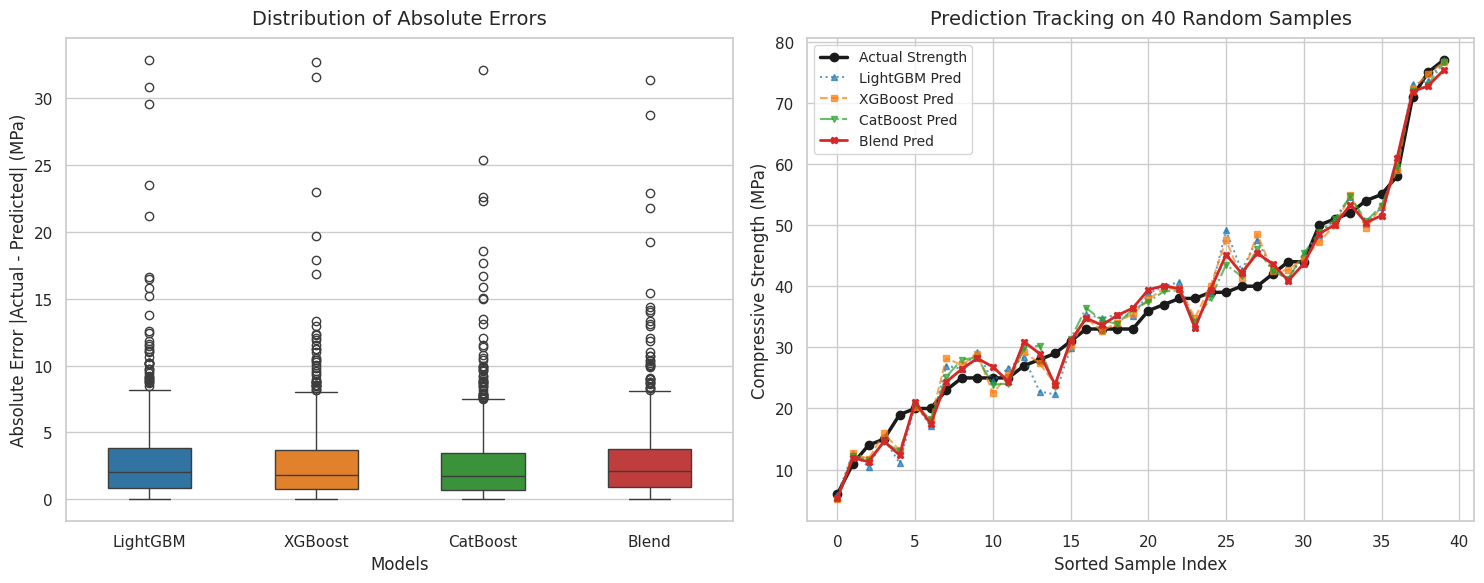

🎉 绘图完成！多模型对比图已保存至 'figs/multi_model_regression_comparison.png'


In [35]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 可视化 – 回归多模型对比：误差箱线图 & 样本追踪图
# ------------------------------------------------------------------
print("正在生成多模型对比评估图表...")

os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight')

# 设置学术风的主题
sns.set_theme(style="whitegrid", palette="muted")
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 准备要对比的 4 个巅峰模型
compare_models = {
    'LightGBM': oof_lgb,
    'XGBoost': oof_xgb,
    'CatBoost': oof_cat,
    'Blend': oof_blend
}

# 统一转换 y 为 numpy 数组，防止索引报错
y_true_array = y.values if isinstance(y, pd.Series) else y

# ==========================================
# 图 1: 绝对误差分布箱线图 (替代 ROC，直观反映误差大小)
# ==========================================
abs_errors = []
labels = []
for name, pred in compare_models.items():
    # 计算每个模型的绝对误差 |真实值 - 预测值|
    abs_errors.extend(np.abs(y_true_array - pred))
    labels.extend([name] * len(y_true_array))

# 使用 DataFrame 方便 seaborn 画图
df_errors = pd.DataFrame({'Model': labels, 'Absolute Error (MPa)': abs_errors})

sns.boxplot(x='Model', y='Absolute Error (MPa)', data=df_errors, ax=ax[0], 
            palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], width=0.5)
ax[0].set_title('Distribution of Absolute Errors', fontsize=14, pad=10)
ax[0].set_ylabel('Absolute Error |Actual - Predicted| (MPa)', fontsize=12)
ax[0].set_xlabel('Models', fontsize=12)

# ==========================================
# 图 2: 样本追踪拟合图 (局部放大对比)
# ==========================================
# 为了图表清晰，我们随机抽取 40 个样本进行折线对比
np.random.seed(42)
sample_indices = np.random.choice(range(len(y_true_array)), size=40, replace=False)

# ⭐️ 核心技巧：将这 40 个样本按真实强度从小到大排序，这样画出来的线更有规律
sample_indices = sample_indices[np.argsort(y_true_array[sample_indices])]
y_true_subset = y_true_array[sample_indices]

# 画出真实的混凝土强度基准线 (黑色实线)
ax[1].plot(range(40), y_true_subset, 'k-o', label='Actual Strength', linewidth=2.5, markersize=6)

# 分别画出 4 个模型的预测折线
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['^', 's', 'v', 'X']
line_styles = [':', '--', '-.', '-'] # 融合模型用实线突出显示

for i, (name, pred) in enumerate(compare_models.items()):
    y_pred_subset = pred[sample_indices]
    alpha_val = 1.0 if name == 'Blend' else 0.7 # 重点突出 Blend 融合模型
    lw_val = 2.0 if name == 'Blend' else 1.5
    
    ax[1].plot(range(40), y_pred_subset, linestyle=line_styles[i], marker=markers[i], 
               color=colors[i], label=f'{name} Pred', alpha=alpha_val, linewidth=lw_val, markersize=5)

ax[1].set_title('Prediction Tracking on 40 Random Samples', fontsize=14, pad=10)
ax[1].set_ylabel('Compressive Strength (MPa)', fontsize=12)
ax[1].set_xlabel('Sorted Sample Index', fontsize=12)
ax[1].legend(fontsize=10)

plt.tight_layout()
save('multi_model_regression_comparison')
plt.show() 
plt.close()

print("🎉 绘图完成！多模型对比图已保存至 'figs/multi_model_regression_comparison.png'")

正在绘制 残差分布密度图 / 累积误差 CDF 曲线...


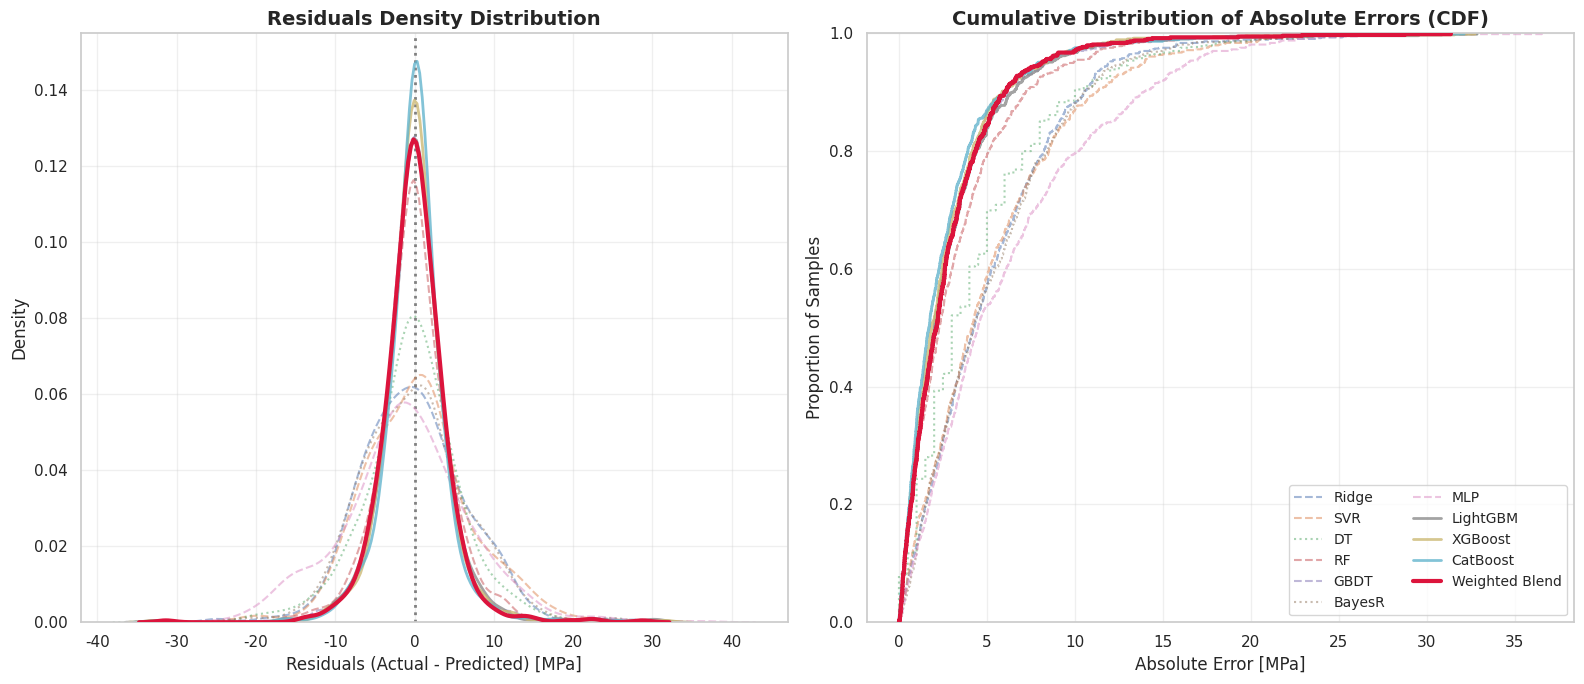

🎉 高级回归模型对比图表生成完毕！图片已保存至 'figs/regression_residuals_cdf_all_models.png'


In [36]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 整理所有模型的绘图参数 (注意：名称已替换为回归模型)
plot_data = [
    # --- 基础模型 (Sklearn) ---
    (oof_lr,   'Ridge',  {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_svm,  'SVR',    {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_dt,   'DT',     {'lw': 1.5, 'alpha': 0.5, 'linestyle': ':'}),
    (oof_rf,   'RF',     {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_gbdt, 'GBDT',   {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    (oof_nb,   'BayesR', {'lw': 1.5, 'alpha': 0.5, 'linestyle': ':'}),
    (oof_mlp,  'MLP',    {'lw': 1.5, 'alpha': 0.5, 'linestyle': '--'}),
    
    # --- 提升树模型 (Boosting) ---
    (oof_lgb,  'LightGBM', {'lw': 2, 'alpha': 0.8}),
    (oof_xgb,  'XGBoost',  {'lw': 2, 'alpha': 0.8}),
    (oof_cat,  'CatBoost', {'lw': 2, 'alpha': 0.8}),
    
    # --- 融合模型 (Ensemble) ---
    # 红色加粗实线，确保它在最上层 (zorder=10)
    (oof_blend, 'Weighted Blend', {'lw': 3, 'alpha': 1.0, 'color': 'crimson', 'zorder': 10}),
]

# 2. 设置绘图环境
os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight')

# 设置 seaborn 主题让图表更具学术感
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# 3. 循环绘图
print("正在绘制 残差分布密度图 / 累积误差 CDF 曲线...")

# --- 图 1: 残差分布密度图 (KDE) ---
# 完美预测的残差为 0，画一条灰色基准线
ax[0].axvline(0, color='gray', linestyle=':', lw=2, label='Zero Error') 

for prob, label, kwargs in plot_data:
    residuals = y - prob  # 计算残差 (真实值 - 预测值)
    sns.kdeplot(residuals, label=label, ax=ax[0], **kwargs)

ax[0].set_title('Residuals Density Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Residuals (Actual - Predicted) [MPa]', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)
ax[0].grid(True, alpha=0.3)
# 左图线太多，为保持整洁，图例只放在右图

# --- 图 2: 绝对误差累积分布函数 (CDF) ---
# 完美替代 ROC！曲线越靠近左上角越好
for prob, label, kwargs in plot_data:
    abs_errors = np.abs(y - prob) # 计算绝对误差
    sns.ecdfplot(abs_errors, label=label, ax=ax[1], **kwargs)

ax[1].set_title('Cumulative Distribution of Absolute Errors (CDF)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Absolute Error [MPa]', fontsize=12)
ax[1].set_ylabel('Proportion of Samples', fontsize=12)
ax[1].grid(True, alpha=0.3)

# 将图例放在右图的右下角，分为两列显示，避免遮挡曲线
ax[1].legend(loc='lower right', fontsize=10, ncol=2)

# 4. 保存与展示
plt.tight_layout()
save('regression_residuals_cdf_all_models')
plt.show()
plt.close()

print("🎉 高级回归模型对比图表生成完毕！图片已保存至 'figs/regression_residuals_cdf_all_models.png'")

>>> [1/3] Loading data and applying SCI-level terminology...
>>> [2/3] Training CatBoost model for interpretation...
>>> [3/3] Generating professional SHAP plots...


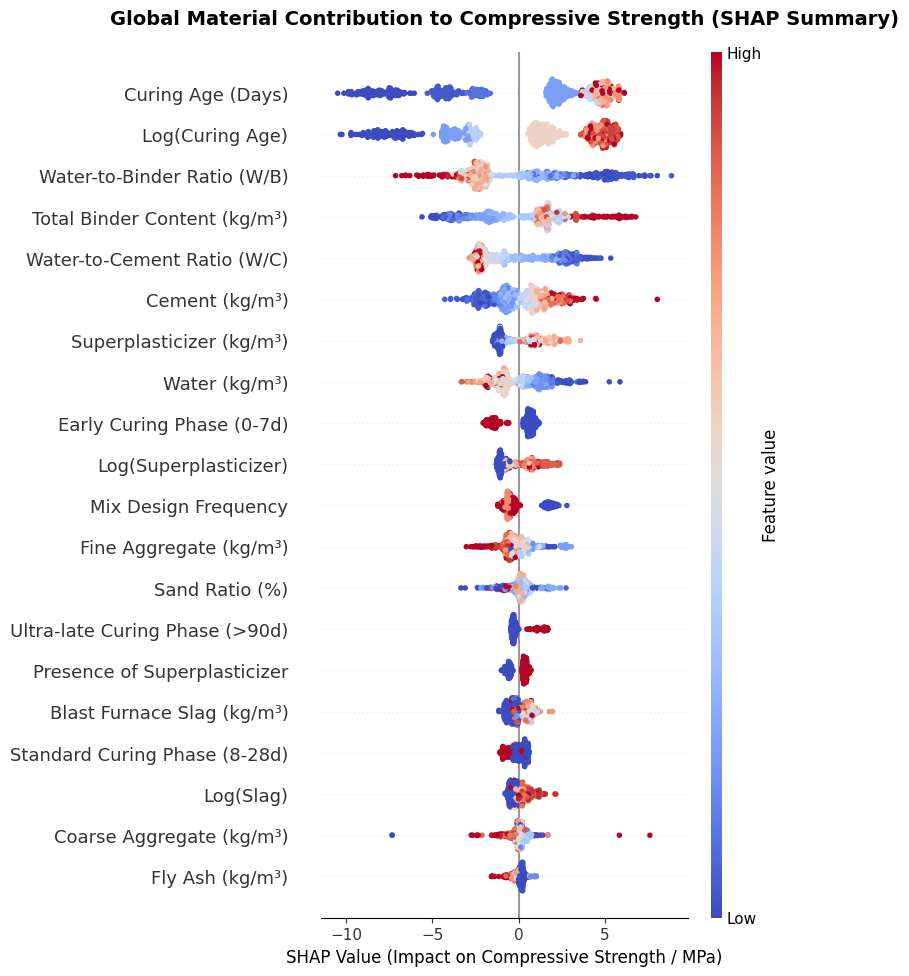

<Figure size 900x700 with 0 Axes>

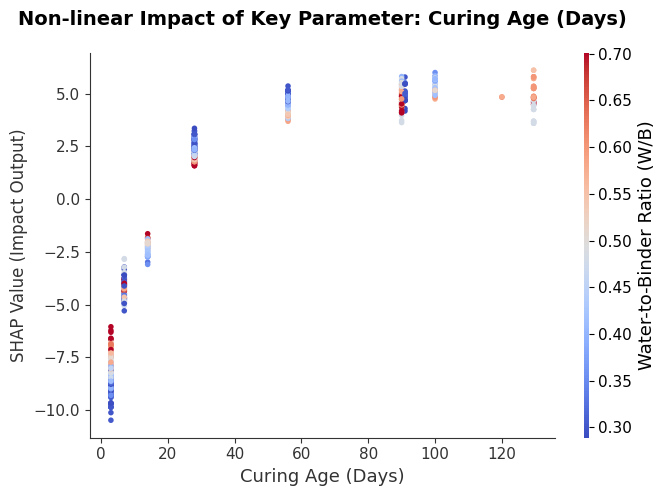

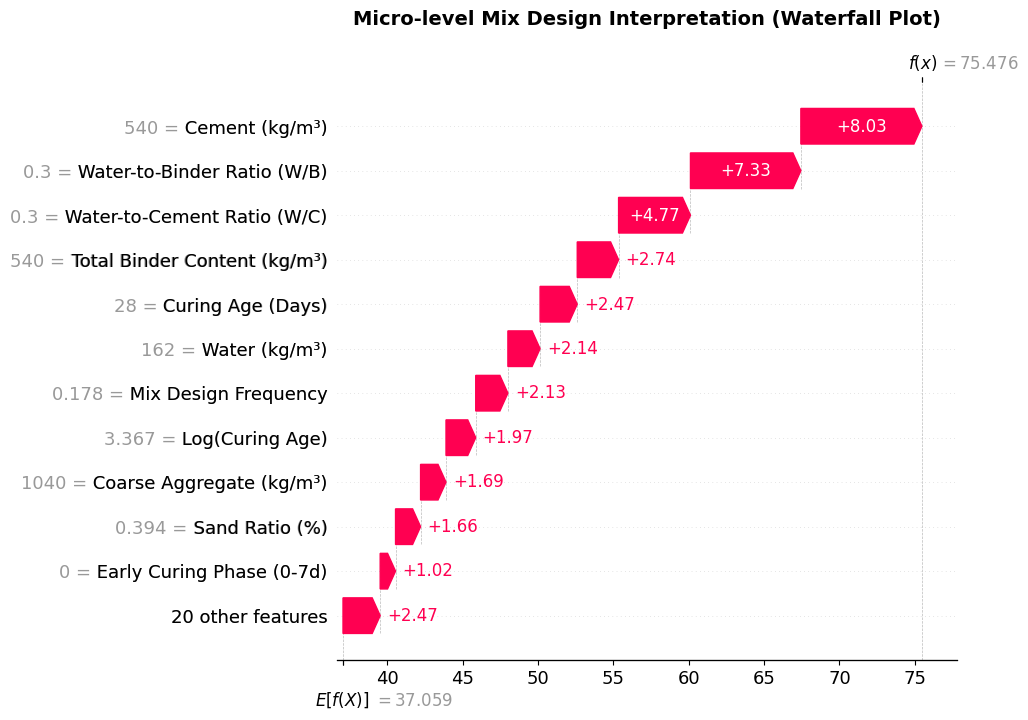


🎉 Done! 缓存已强制清理，全英文国际顶刊标准图表生成完毕！


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from catboost import CatBoostRegressor
import warnings
import logging

# ======================================================
# 0. 强力清除 Jupyter 内存残留 & 屏蔽烦人警告
# ======================================================
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True # 直接禁言字体管理器的报错

# 🌟 核心修复：强制重置 Matplotlib 到出厂默认纯英文状态！洗掉之前的中文残留！
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica', 'sans-serif']

# ======================================================
# 1. 建立顶级英文学术术语词典 (SCI Journal Standard)
# ======================================================
sci_engineering_dict = {
    # 基础材料
    'Cement': 'Cement (kg/m³)',
    'Blast Furnace Slag': 'Blast Furnace Slag (kg/m³)',
    'Fly Ash': 'Fly Ash (kg/m³)',
    'Water': 'Water (kg/m³)',
    'Superplasticizer': 'Superplasticizer (kg/m³)',
    'Coarse Aggregate': 'Coarse Aggregate (kg/m³)',
    'Fine Aggregate': 'Fine Aggregate (kg/m³)',
    'Age (day)': 'Curing Age (Days)',
    
    # 高级衍生特征
    'Water_Cement_Ratio': 'Water-to-Cement Ratio (W/C)',
    'Total_Binder': 'Total Binder Content (kg/m³)',
    'Water_Binder_Ratio': 'Water-to-Binder Ratio (W/B)',
    'Sand_Ratio': 'Sand Ratio (%)',
    
    # 类别特征
    'has_Superplasticizer': 'Presence of Superplasticizer',
    'has_FlyAsh': 'Presence of Fly Ash',
    'mix_type_freq': 'Mix Design Frequency',
    
    # 养护阶段独热编码
    'Age_Phase_OHE_0.0': 'Early Curing Phase (0-7d)',
    'Age_Phase_OHE_1.0': 'Standard Curing Phase (8-28d)',
    'Age_Phase_OHE_2.0': 'Late Curing Phase (29-90d)',
    'Age_Phase_OHE_3.0': 'Ultra-late Curing Phase (>90d)',
    
    # 对数特征
    'Age (day)_log1p': 'Log(Curing Age)',
    'Superplasticizer_log1p': 'Log(Superplasticizer)',
    'Fly Ash_log1p': 'Log(Fly Ash)',
    'Blast Furnace Slag_log1p': 'Log(Slag)'
}

# ======================================================
# 2. 数据加载与英文术语替换
# ======================================================
print(">>> [1/3] Loading data and applying SCI-level terminology...")
df_saved = pd.read_csv('train_fe_final.csv')

target_col = 'Concrete compressive strength'
drop_cols = [target_col, 'Strength_Level']

# 提取特征并重命名为英文专业术语
X_raw = df_saved.drop(columns=[col for col in drop_cols if col in df_saved.columns])
X_shap = X_raw.rename(columns=sci_engineering_dict).astype(float)
y = df_saved[target_col].astype(float)

# ======================================================
# 3. 现场训练模型
# ======================================================
print(">>> [2/3] Training CatBoost model for interpretation...")
m_cat = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=False, random_state=42)
m_cat.fit(X_shap, y)

# ======================================================
# 4. 计算并绘制符合学术规范的 SHAP 图表
# ======================================================
print(">>> [3/3] Generating professional SHAP plots...")
os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight')

explainer = shap.TreeExplainer(m_cat)
shap_values = explainer.shap_values(X_shap)
shap_v = shap_values[0] if isinstance(shap_values, list) else shap_values

# --- 图 1：SHAP 摘要图 ---
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_v, X_shap, show=False, cmap='coolwarm')
plt.title('Global Material Contribution to Compressive Strength (SHAP Summary)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Compressive Strength / MPa)', fontsize=12)
save('shap_sci_summary')
plt.show()

# --- 图 2：核心依赖图 ---
top_feat_idx = np.abs(shap_v).mean(axis=0).argmax()
top_feat_name = X_shap.columns[top_feat_idx]

plt.figure(figsize=(9, 7))
shap.dependence_plot(top_feat_name, shap_v, X_shap, show=False, cmap='coolwarm')
plt.title(f'Non-linear Impact of Key Parameter: {top_feat_name}', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('SHAP Value (Impact Output)', fontsize=12)
safe_name = str(top_feat_name).replace("/", "_").replace(" ", "_").replace("(", "").replace(")", "").replace(">", "gt")
save(f'shap_sci_dependence_{safe_name}')
plt.show()

# --- 图 3：单一样本瀑布图 ---
plt.figure(figsize=(12, 8))
ev = explainer.expected_value
if isinstance(ev, (list, np.ndarray)): ev = ev[0]

shap_exp = shap.Explanation(
    values=shap_v[0], 
    base_values=ev, 
    data=X_shap.iloc[0].values, 
    feature_names=list(X_shap.columns)
)
shap.waterfall_plot(shap_exp, max_display=12, show=False)
plt.title('Micro-level Mix Design Interpretation (Waterfall Plot)', fontsize=14, fontweight='bold', pad=20)
save('shap_sci_waterfall')
plt.show()

print("\n🎉 Done! 缓存已强制清理，全英文国际顶刊标准图表生成完毕！")

>>> 正在准备 SHAP 解释性分析数据...
>>> 正在计算 SHAP 值 (以最佳模型 CatBoost 代表)...
>>> 绘制 1/4: SHAP 摘要蜂群图...


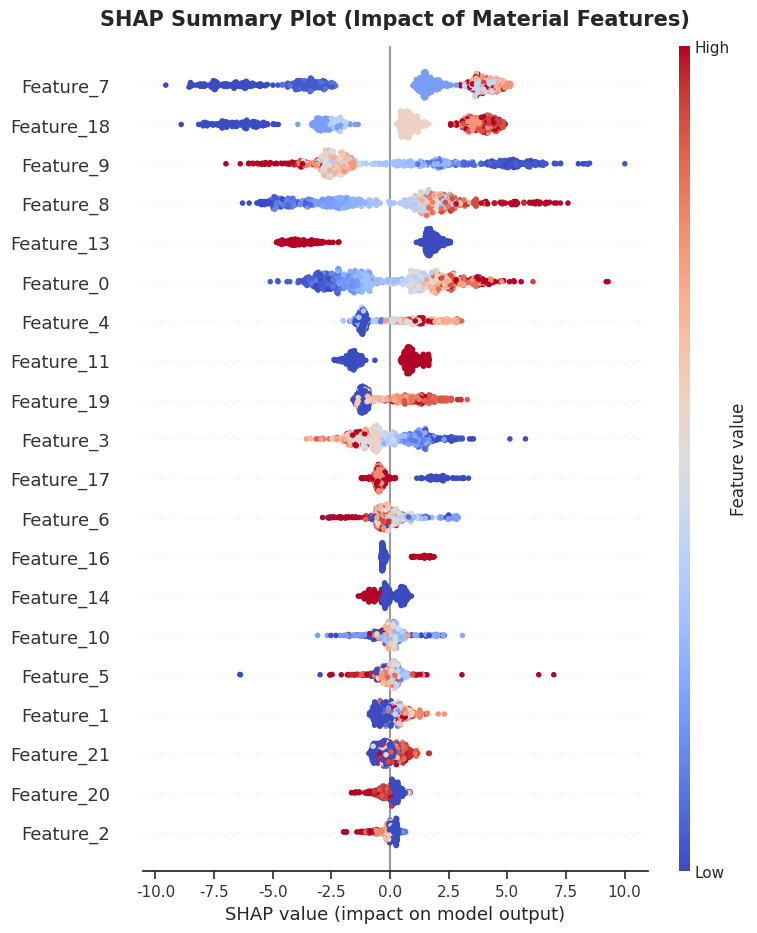

>>> 绘制 2/4: 全局特征重要性条形图...


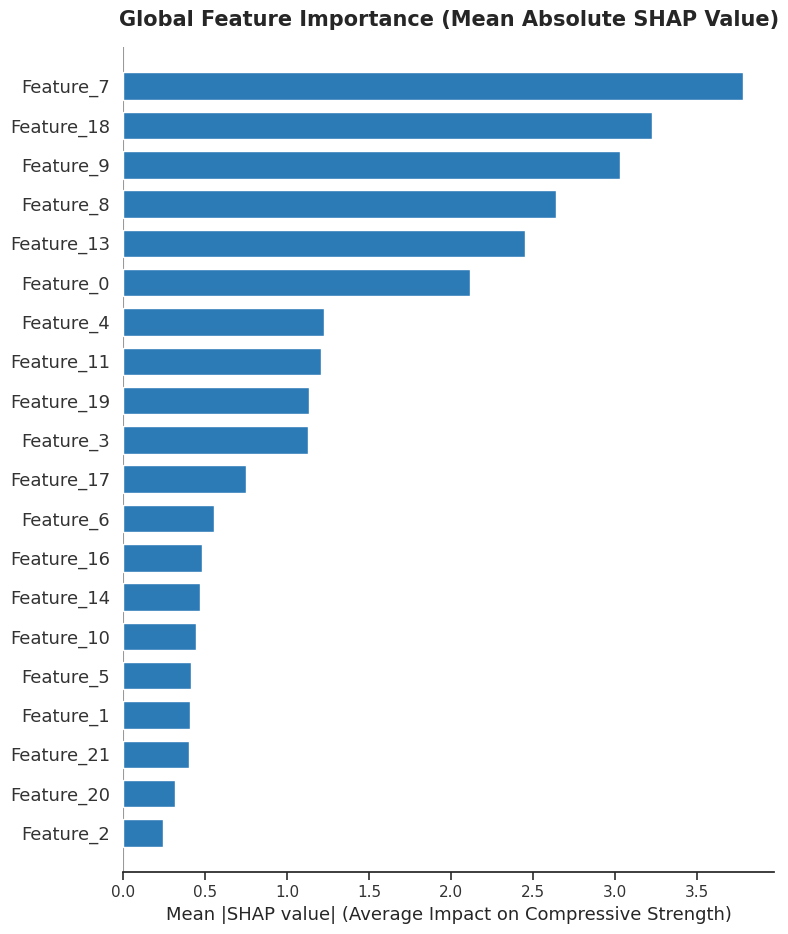

>>> 绘制 3/4: 最重要特征的依赖图...


<Figure size 800x600 with 0 Axes>

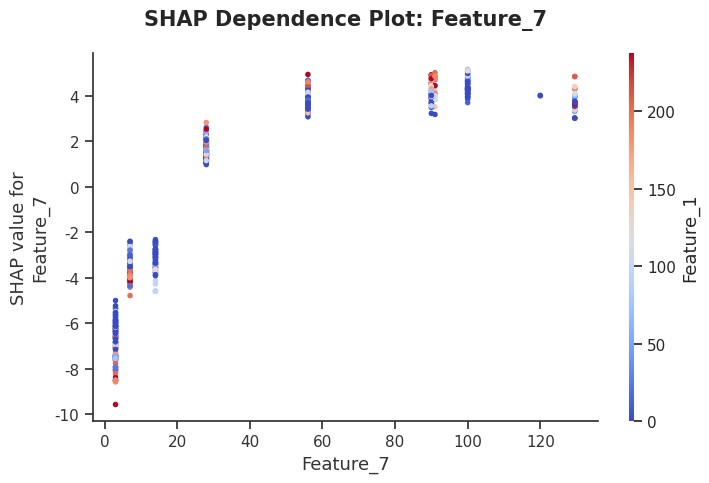

>>> 绘制 4/4: 单一样本微观推演瀑布图...


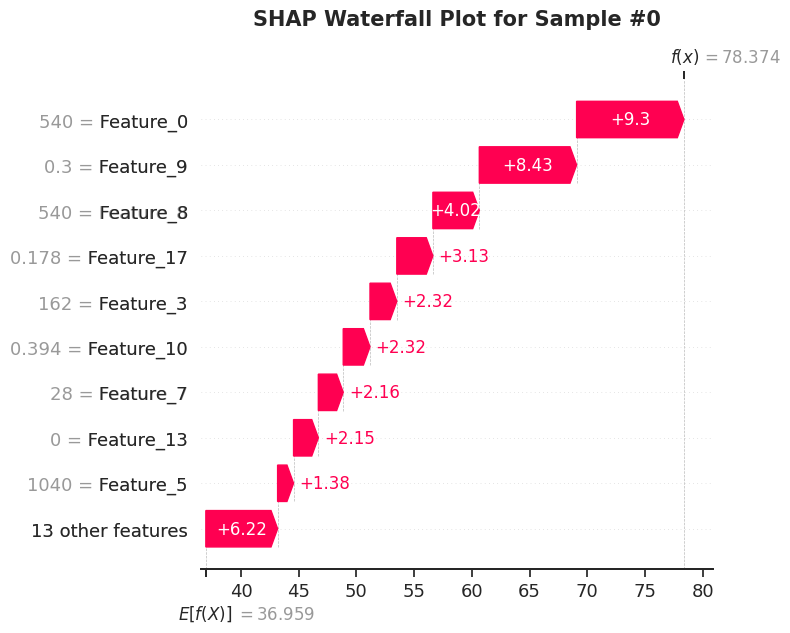


🎉 恭喜！四大神图全部生成完毕，已保存至 'figs' 文件夹！


In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ======================================================
# 0. 数据清洗与特征名对齐 (彻底消灭 object 报错)
# ======================================================
print(">>> 正在准备 SHAP 解释性分析数据...")

# 智能提取特征名：兼容不同的数据格式
if 'X_sample' in globals() and hasattr(X_sample, 'columns'):
    feat_names = list(X_sample.columns)
elif isinstance(X_full, pd.DataFrame):
    feat_names = list(X_full.columns)
else:
    feat_names = [f'Feature_{i}' for i in range(X_full.shape[1])]

# 强制转换数据类型为 float，生成 SHAP 专用 DataFrame
X_shap = pd.DataFrame(X_full, columns=feat_names).astype(float)

# 创建图片保存目录
os.makedirs('figs', exist_ok=True)
save = lambda name: plt.savefig(f'figs/{name}.png', dpi=300, bbox_inches='tight', transparent=False)

# ======================================================
# 1. 实例化 SHAP 解释器 (以 CatBoost 为例)
# ======================================================
print(">>> 正在计算 SHAP 值 (以最佳模型 CatBoost 代表)...")
# 对于 CatBoost，直接传入模型实例即可
explainer = shap.TreeExplainer(m_cat)

# 为了绘图速度，如果数据量太大可以采样 (例如前 2000 个)，这里默认全量
shap_values = explainer.shap_values(X_shap)

# 兼容性处理：回归任务中有时返回 list，有时返回 array
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[0]
else:
    shap_values_to_plot = shap_values

# 提取 Expected Value (基准值)
expected_value = explainer.expected_value
if isinstance(expected_value, (list, np.ndarray)):
    expected_value = expected_value[0]

# ======================================================
# 2. 绘制图 1：SHAP 摘要蜂群图 (Beeswarm)
# ======================================================
print(">>> 绘制 1/4: SHAP 摘要蜂群图...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_to_plot, X_shap, show=False, cmap='coolwarm')
plt.title('SHAP Summary Plot (Impact of Material Features)', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
save('shap_summary_beeswarm')
plt.show()
plt.close()

# ======================================================
# 3. 绘制图 2：SHAP 全局特征重要性条形图 (Bar)
# ======================================================
print(">>> 绘制 2/4: 全局特征重要性条形图...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_to_plot, X_shap, plot_type="bar", show=False, color='#2c7bb6')
plt.title('Global Feature Importance (Mean Absolute SHAP Value)', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Mean |SHAP value| (Average Impact on Compressive Strength)')
plt.tight_layout()
save('shap_summary_bar')
plt.show()
plt.close()

# ======================================================
# 4. 绘制图 3：SHAP 依赖图 (Dependence Plot)
# ======================================================
print(">>> 绘制 3/4: 最重要特征的依赖图...")
# 自动找出平均绝对 SHAP 值最大的特征 (即最重要的特征)
top_feat_idx = np.abs(shap_values_to_plot).mean(axis=0).argmax()
top_feat_name = feat_names[top_feat_idx]

plt.figure(figsize=(8, 6))
# 绘制依赖图，SHAP 会自动挑一个相关性最强的特征进行颜色映射 (交互效应)
shap.dependence_plot(top_feat_name, shap_values_to_plot, X_shap, show=False, cmap='coolwarm')
plt.title(f'SHAP Dependence Plot: {top_feat_name}', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
save(f'shap_dependence_{top_feat_name}')
plt.show()
plt.close()

# ======================================================
# 5. 绘制图 4：单样本微观剖析瀑布图 (Waterfall Plot)
# ======================================================
print(">>> 绘制 4/4: 单一样本微观推演瀑布图...")
# 随机挑一个样本，或者你可以指定一个高强度/低强度的特定样本索引
sample_idx = 0 

plt.figure(figsize=(10, 6))
# 新版 SHAP 瀑布图需要传入 Explanation 对象
shap_exp = shap.Explanation(values=shap_values_to_plot[sample_idx],
                            base_values=expected_value,
                            data=X_shap.iloc[sample_idx].values,
                            feature_names=feat_names)

shap.waterfall_plot(shap_exp, max_display=10, show=False)
plt.title(f'SHAP Waterfall Plot for Sample #{sample_idx}', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
save('shap_waterfall_sample')
plt.show()
plt.close()

print("\n🎉 恭喜！四大神图全部生成完毕，已保存至 'figs' 文件夹！")

# <a id='toc9_'></a>[合成数据生成](#toc0_)
功能：通过KNN插值法为少数类生成合成样本，缓解数据不平衡问题